In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
#import folium
from datetime import datetime,date
from scipy.interpolate import make_interp_spline, BSpline
from lmfit import Minimizer, Parameters, report_fit
import chart_studio.plotly as py

%matplotlib inline
from lmfit import Minimizer, Parameters, report_fit
import os

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf

In [2]:
def Reverse(lst): 
    return [ele for ele in reversed(lst)]

In [3]:
path='data/COVID19/JHU/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series'
confirmed_fn=os.path.join(path,'time_series_covid19_confirmed_global.csv')
deaths_fn=os.path.join(path,'time_series_covid19_deaths_global.csv')
recovered_fn=os.path.join(path,'time_series_covid19_recovered_global.csv')

In [4]:
df_confirmed = pd.read_csv(confirmed_fn)
df_deaths = pd.read_csv(deaths_fn)
df_recovered = pd.read_csv(recovered_fn)

In [5]:
Rows2,Cols2=df_confirmed.shape
cols2=df_confirmed.columns
#cols1

# @interact
# def show_df_confirmed(columns=cols2,x=(1,Rows2,1)):
#     return df_active.iloc[x:x+5]

In [6]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [7]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"

df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])

In [8]:
df_active = df_confirmed.copy()
df_active.iloc[:,5:] = df_active.iloc[:,5:] - df_recovered.iloc[:,5:] - df_deaths.iloc[:,5:]


In [9]:
Rows,Cols=df_active.shape
cols1=df_active.columns
#cols1

@interact
def show_df_active(columns=cols1,x=(1,Rows,1)):
    return df_active.iloc[x:x+5]

interactive(children=(Dropdown(description='columns', options=('state', 'country', 'Lat', 'Long', '1/22/20', '…

In [10]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
df_recovered = df_recovered.replace(np.nan, '', regex=True)
df_active = df_active.replace(np.nan, '', regex=True)

In [11]:
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days

In [12]:
confirmed_cases =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
recovered_cases = df_recovered.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
deaths = df_deaths.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
active_cases = df_active.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]

confirmed_cases.name = "Confirmed Cases"
recovered_cases.name = "Recovered Cases"
deaths.name = "Deaths Reported"
active_cases.name = "Active Cases"
df_countries_cases = pd.DataFrame([confirmed_cases,recovered_cases,deaths,active_cases]).transpose()

In [13]:
LL,tt=df_countries_cases.shape
cols=df_countries_cases.columns
cols

Index(['Confirmed Cases', 'Recovered Cases', 'Deaths Reported',
       'Active Cases'],
      dtype='object')

In [14]:
@interact
def show_df_countries_cases(column=cols, x=(1,LL,1)):
    return df_countries_cases.iloc[x:x+5]

interactive(children=(Dropdown(description='column', options=('Confirmed Cases', 'Recovered Cases', 'Deaths Re…

In [15]:
Top10_Deaths=list(df_countries_cases.sort_values('Deaths Reported')["Deaths Reported"].index[-10:])
Top10_Confirmed=list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-10:])
Top10_Recovered=list(df_countries_cases.sort_values('Recovered Cases')["Recovered Cases"].index[-10:])
Top10_Active=list(df_countries_cases.sort_values('Active Cases')["Active Cases"].index[-10:])

In [16]:
Top10_Confirmed=Reverse(list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-10:]))

In [17]:
confirmed_series =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Confirmed].T
recovered_series = df_recovered.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Confirmed].T
deaths_series = df_deaths.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Recovered].T
active_series = df_active.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Active].T

In [18]:

Top21_Confirmed=Reverse(list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-62:]))


In [19]:
confirmed_series_21 =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top21_Confirmed].T


In [20]:
def Cauchy_cumulative_hazard(x,loc,scale,decaybase):
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    return -np.log(0.5 - np.arctan(z)/np.pi)

# define objective function: returns the array to be minimized
def Cauchy_cumulative_hazard_residual(params, x, data):
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    loc = params['loc']
    scale = params['scale']
    decaybase=params['decaybase']
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    model = amp * (-np.log(0.5 - np.arctan(z)/np.pi))
    return model - data

In [21]:
print(Top21_Confirmed)

['USA', 'Spain', 'Italy', 'United Kingdom', 'Russia', 'France', 'Germany', 'Brazil', 'Turkey', 'Iran', 'China', 'Canada', 'Peru', 'India', 'Belgium', 'Netherlands', 'Saudi Arabia', 'Ecuador', 'Switzerland', 'Mexico', 'Portugal', 'Pakistan', 'Sweden', 'Chile', 'Ireland', 'Singapore', 'Belarus', 'Qatar', 'Israel', 'United Arab Emirates', 'Austria', 'Japan', 'Poland', 'Romania', 'Ukraine', 'Indonesia', 'Bangladesh', 'South Korea', 'Philippines', 'Denmark', 'Serbia', 'Colombia', 'Dominican Republic', 'South Africa', 'Norway', 'Czechia', 'Egypt', 'Panama', 'Australia', 'Kuwait', 'Malaysia', 'Finland', 'Morocco', 'Argentina', 'Algeria', 'Moldova', 'Kazakhstan', 'Bahrain', 'Luxembourg', 'Afghanistan', 'Nigeria', 'Hungary']


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 188
    # data points      = 103
    # variables        = 4
    chi-square         = 0.01308771
    reduced chi-square = 1.3220e-04
    Akaike info crit   = -915.993529
    Bayesian info crit = -905.454613
[[Variables]]
    amp:        0.10544801 +/- 0.01001213 (9.49%) (init = 1)
    scale:      7.28338296 +/- 0.64951310 (8.92%) (init = 1)
    loc:        62.9982311 +/- 0.54771569 (0.87%) (init = 70)
    decaybase:  0.85000000 +/- 0.00558646 (0.66%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.903
    C(amp, loc)         =  0.895
    C(scale, loc)       = -0.774
    C(scale, decaybase) =  0.547
    C(amp, scale)       = -0.498


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pand

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10001
    # data points      = 73
    # variables        = 4
    chi-square         = 1.72533480
    reduced chi-square = 0.02500485
    Akaike info crit   = -265.387798
    Bayesian info crit = -256.225960
##  Warning: uncertainties could not be estimated:
    decaybase:  at boundary
[[Variables]]
    amp:        1.03131968 (init = 1)
    scale:      26.0168327 (init = 1)
    loc:        54.4648752 (init = 70)
    decaybase:  1.00499517 (init = 1)


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5230
    # data points      = 77
    # variables        = 4
    chi-square         = 0.01207030
    reduced chi-square = 1.6535e-04
    Akaike info crit   = -666.582562
    Bayesian info crit = -657.207340
[[Variables]]
    amp:        0.20940296 +/- 0.00952136 (4.55%) (init = 1)
    scale:      6.09309753 +/- 0.27085413 (4.45%) (init = 1)
    loc:        26.5579966 +/- 0.34182935 (1.29%) (init = 70)
    decaybase:  0.96760816 +/- 0.00371038 (0.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.980
    C(loc, decaybase)   =  0.888
    C(amp, loc)         =  0.862
    C(amp, scale)       =  0.700
    C(scale, decaybase) =  0.562
    C(scale, loc)       =  0.339


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 214
    # data points      = 88
    # variables        = 4
    chi-square         = 0.01395323
    reduced chi-square = 1.6611e-04
    Akaike info crit   = -761.945524
    Bayesian info crit = -752.036177
[[Variables]]
    amp:        0.10896873 +/- 0.01257832 (11.54%) (init = 1)
    scale:      8.57183487 +/- 0.99481035 (11.61%) (init = 1)
    loc:        49.2967834 +/- 0.70272909 (1.43%) (init = 70)
    decaybase:  0.85000001 +/- 0.03698431 (4.35%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.926
    C(amp, loc)         =  0.921
    C(scale, loc)       = -0.869
    C(scale, decaybase) =  0.721
    C(amp, scale)       = -0.685


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 160
    # data points      = 64
    # variables        = 4
    chi-square         = 0.04565632
    reduced chi-square = 7.6094e-04
    Akaike info crit   = -455.711761
    Bayesian info crit = -447.076229
[[Variables]]
    amp:        0.26886978 +/- 0.12310888 (45.79%) (init = 1)
    scale:      7.94167452 +/- 2.26893366 (28.57%) (init = 1)
    loc:        45.5179035 +/- 3.35321882 (7.37%) (init = 70)
    decaybase:  0.92529651 +/- 0.07163433 (7.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.996
    C(loc, decaybase)   =  0.993
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.965
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 101
    # variables        = 4
    chi-square         = 0.11550257
    reduced chi-square = 0.00119075
    Akaike info crit   = -676.131881
    Bayesian info crit = -665.671399
[[Variables]]
    amp:        0.39072479 +/- 0.03147761 (8.06%) (init = 1)
    scale:      6.90832580 +/- 0.48374531 (7.00%) (init = 1)
    loc:        64.4937238 +/- 0.79258398 (1.23%) (init = 70)
    decaybase:  1.00500000 +/- 2.5248e-04 (0.03%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.930
    C(amp, decaybase)   =  0.929
    C(loc, decaybase)   =  0.906
    C(amp, scale)       =  0.681
    C(scale, loc)       =  0.491
    C(scale, decaybase) =  0.387


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 101
    # variables        = 4
    chi-square         = 0.02352570
    reduced chi-square = 2.4253e-04
    Akaike info crit   = -836.843027
    Bayesian info crit = -826.382545
[[Variables]]
    amp:        0.29170341 +/- 0.01092670 (3.75%) (init = 1)
    scale:      4.97262518 +/- 0.22850481 (4.60%) (init = 1)
    loc:        57.7793886 +/- 0.26542819 (0.46%) (init = 70)
    decaybase:  0.99560138 +/- 0.00243651 (0.24%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.937
    C(loc, decaybase)   =  0.866
    C(amp, loc)         =  0.839
    C(amp, scale)       =  0.805
    C(scale, decaybase) =  0.566
    C(scale, loc)       =  0.471


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 154
    # data points      = 65
    # variables        = 4
    chi-square         = 0.05069184
    reduced chi-square = 8.3101e-04
    Akaike info crit   = -457.164540
    Bayesian info crit = -448.466991
[[Variables]]
    amp:        0.34699732 +/- 0.12179064 (35.10%) (init = 1)
    scale:      10.9207280 +/- 2.29028704 (20.97%) (init = 1)
    loc:        46.5334783 +/- 3.57911995 (7.69%) (init = 70)
    decaybase:  0.94788422 +/- 0.04004868 (4.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.993
    C(loc, decaybase)   =  0.987
    C(scale, decaybase) = -0.971
    C(scale, loc)       = -0.955
    C(amp, scale)       = -0.950


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 56
    # variables        = 4
    chi-square         = 0.01565531
    reduced chi-square = 3.0106e-04
    Akaike info crit   = -450.208608
    Bayesian info crit = -442.107201
[[Variables]]
    amp:        0.23114045 +/- 0.02168133 (9.38%) (init = 1)
    scale:      5.76545221 +/- 0.31085538 (5.39%) (init = 1)
    loc:        23.1174313 +/- 0.62609071 (2.71%) (init = 70)
    decaybase:  0.95458173 +/- 0.01082678 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.952
    C(amp, loc)         =  0.945
    C(amp, scale)       =  0.398
    C(scale, decaybase) =  0.269
    C(scale, loc)       =  0.165


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1948
    # data points      = 78
    # variables        = 4
    chi-square         = 0.02498458
    reduced chi-square = 3.3763e-04
    Akaike info crit   = -619.604015
    Bayesian info crit = -610.177180
[[Variables]]
    amp:        0.31288424 +/- 0.01937241 (6.19%) (init = 1)
    scale:      8.95675883 +/- 0.36912660 (4.12%) (init = 1)
    loc:        32.3762042 +/- 0.70930163 (2.19%) (init = 70)
    decaybase:  0.99135773 +/- 0.00369103 (0.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.970
    C(amp, loc)         =  0.953
    C(loc, decaybase)   =  0.949
    C(amp, scale)       =  0.635
    C(scale, loc)       =  0.465
    C(scale, decaybase) =  0.449


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 799
    # data points      = 107
    # variables        = 4
    chi-square         = 0.40725600
    reduced chi-square = 0.00395394
    Akaike info crit   = -588.112208
    Bayesian info crit = -577.420892
[[Variables]]
    amp:        0.20809512 +/- 0.01980140 (9.52%) (init = 1)
    scale:      1.14120137 +/- 0.37866145 (33.18%) (init = 1)
    loc:        12.6238710 +/- 0.33242261 (2.63%) (init = 70)
    decaybase:  1.00500000 +/- 7.9087e-04 (0.08%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.974
    C(amp, decaybase)   = -0.851
    C(scale, decaybase) = -0.723
    C(scale, loc)       = -0.342
    C(amp, loc)         = -0.238


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 314
    # data points      = 98
    # variables        = 4
    chi-square         = 0.03880059
    reduced chi-square = 4.1277e-04
    Akaike info crit   = -759.760150
    Bayesian info crit = -749.420280
[[Variables]]
    amp:        0.11104695 +/- 0.02099232 (18.90%) (init = 1)
    scale:      10.1204624 +/- 2.13147888 (21.06%) (init = 1)
    loc:        59.6754063 +/- 1.21470301 (2.04%) (init = 70)
    decaybase:  0.85000000 +/- 2.2381e-04 (0.03%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.937
    C(amp, loc)         =  0.935
    C(scale, loc)       = -0.920
    C(scale, decaybase) =  0.820
    C(amp, scale)       = -0.793


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 61
    # variables        = 4
    chi-square         = 0.05246575
    reduced chi-square = 9.2045e-04
    Akaike info crit   = -422.566579
    Bayesian info crit = -414.123084
[[Variables]]
    amp:        0.32087602 +/- 0.13868138 (43.22%) (init = 1)
    scale:      9.37225555 +/- 2.40405387 (25.65%) (init = 1)
    loc:        42.8319995 +/- 3.80011443 (8.87%) (init = 70)
    decaybase:  0.94073122 +/- 0.05680341 (6.04%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.996
    C(loc, decaybase)   =  0.991
    C(scale, decaybase) = -0.972
    C(scale, loc)       = -0.961
    C(amp, scale)       = -0.955


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 67
    # variables        = 4
    chi-square         = 0.06840775
    reduced chi-square = 0.00108584
    Akaike info crit   = -453.426440
    Bayesian info crit = -444.607669
[[Variables]]
    amp:        0.29504456 +/- 0.14673028 (49.73%) (init = 1)
    scale:      10.0030672 +/- 2.93213812 (29.31%) (init = 1)
    loc:        46.2238022 +/- 4.67450227 (10.11%) (init = 70)
    decaybase:  0.94459952 +/- 0.06123067 (6.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.993
    C(scale, decaybase) = -0.972
    C(scale, loc)       = -0.964
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 284
    # data points      = 67
    # variables        = 4
    chi-square         = 0.02555801
    reduced chi-square = 4.0568e-04
    Akaike info crit   = -519.390313
    Bayesian info crit = -510.571543
[[Variables]]
    amp:        0.21857384 +/- 0.02070706 (9.47%) (init = 1)
    scale:      6.32742382 +/- 0.39294445 (6.21%) (init = 1)
    loc:        27.0700625 +/- 0.69488758 (2.57%) (init = 70)
    decaybase:  0.95637514 +/- 0.00974631 (1.02%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.938
    C(amp, loc)         =  0.927
    C(amp, scale)       =  0.455
    C(scale, decaybase) =  0.327
    C(scale, loc)       =  0.180


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 217
    # data points      = 69
    # variables        = 4
    chi-square         = 0.02863897
    reduced chi-square = 4.4060e-04
    Akaike info crit   = -529.309437
    Bayesian info crit = -520.373011
[[Variables]]
    amp:        0.22362693 +/- 0.02145616 (9.59%) (init = 1)
    scale:      6.77124321 +/- 0.42038949 (6.21%) (init = 1)
    loc:        26.8943946 +/- 0.75465533 (2.81%) (init = 70)
    decaybase:  0.96084513 +/- 0.00915265 (0.95%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.941
    C(amp, loc)         =  0.931
    C(amp, scale)       =  0.469
    C(scale, decaybase) =  0.340
    C(scale, loc)       =  0.204


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 64
    # variables        = 4
    chi-square         = 0.01898838
    reduced chi-square = 3.1647e-04
    Akaike info crit   = -511.859906
    Bayesian info crit = -503.224373
[[Variables]]
    amp:        0.27098822 +/- 0.06304287 (23.26%) (init = 1)
    scale:      9.40049985 +/- 1.52172743 (16.19%) (init = 1)
    loc:        43.2159441 +/- 1.92871545 (4.46%) (init = 70)
    decaybase:  0.92773326 +/- 0.03313739 (3.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.996
    C(amp, loc)         =  0.995
    C(loc, decaybase)   =  0.990
    C(scale, decaybase) = -0.966
    C(scale, loc)       = -0.961
    C(amp, scale)       = -0.949


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 68
    # variables        = 4
    chi-square         = 0.17892179
    reduced chi-square = 0.00279565
    Akaike info crit   = -395.941366
    Bayesian info crit = -387.063335
[[Variables]]
    amp:        0.32726255 +/- 0.17347838 (53.01%) (init = 1)
    scale:      10.7361089 +/- 4.00900788 (37.34%) (init = 1)
    loc:        45.4250295 +/- 4.99211520 (10.99%) (init = 70)
    decaybase:  0.93562032 +/- 0.06728144 (7.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.996
    C(amp, loc)         =  0.994
    C(loc, decaybase)   =  0.989
    C(scale, decaybase) = -0.965
    C(scale, loc)       = -0.958
    C(amp, scale)       = -0.947


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10000
    # data points      = 71
    # variables        = 4
    chi-square         = 0.72829821
    reduced chi-square = 0.01087012
    Akaike info crit   = -317.160444
    Bayesian info crit = -308.109725
##  Warning: uncertainties could not be estimated:
    decaybase:  at boundary
[[Variables]]
    amp:        0.61974911 (init = 1)
    scale:      17.2230289 (init = 1)
    loc:        33.1058199 (init = 70)
    decaybase:  1.00499611 (init = 1)


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 69
    # variables        = 4
    chi-square         = 0.03753577
    reduced chi-square = 5.7747e-04
    Akaike info crit   = -510.643150
    Bayesian info crit = -501.706724
[[Variables]]
    amp:        0.30823732 +/- 0.09660018 (31.34%) (init = 1)
    scale:      10.0352035 +/- 1.99757286 (19.91%) (init = 1)
    loc:        49.2952904 +/- 2.88304511 (5.85%) (init = 70)
    decaybase:  0.93989018 +/- 0.03994583 (4.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.996
    C(amp, decaybase)   =  0.995
    C(loc, decaybase)   =  0.990
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.961
    C(amp, scale)       = -0.953


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 504
    # data points      = 65
    # variables        = 4
    chi-square         = 0.01983319
    reduced chi-square = 3.2513e-04
    Akaike info crit   = -518.161079
    Bayesian info crit = -509.463530
[[Variables]]
    amp:        0.21462876 +/- 0.01522867 (7.10%) (init = 1)
    scale:      5.17060173 +/- 0.34052323 (6.59%) (init = 1)
    loc:        24.2939949 +/- 0.45356138 (1.87%) (init = 70)
    decaybase:  0.96259396 +/- 0.00692729 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.980
    C(loc, decaybase)   =  0.898
    C(amp, loc)         =  0.876
    C(amp, scale)       =  0.681
    C(scale, decaybase) =  0.539
    C(scale, loc)       =  0.342


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 69
    # variables        = 4
    chi-square         = 0.05538661
    reduced chi-square = 8.5210e-04
    Akaike info crit   = -483.799148
    Bayesian info crit = -474.862722
[[Variables]]
    amp:        0.34728476 +/- 0.11208580 (32.27%) (init = 1)
    scale:      12.4940245 +/- 2.45644661 (19.66%) (init = 1)
    loc:        47.5006473 +/- 3.73055533 (7.85%) (init = 70)
    decaybase:  0.95290719 +/- 0.03276721 (3.44%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.996
    C(amp, decaybase)   =  0.993
    C(loc, decaybase)   =  0.987
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.954
    C(amp, scale)       = -0.949


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10003
    # data points      = 71
    # variables        = 4
    chi-square         = 0.29274315
    reduced chi-square = 0.00436930
    Akaike info crit   = -381.870907
    Bayesian info crit = -372.820188
##  Warning: uncertainties could not be estimated:
    decaybase:  at boundary
[[Variables]]
    amp:        0.79498456 (init = 1)
    scale:      17.2988293 (init = 1)
    loc:        54.1413223 (init = 70)
    decaybase:  1.00499036 (init = 1)


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 173
    # data points      = 64
    # variables        = 4
    chi-square         = 0.12500523
    reduced chi-square = 0.00208342
    Akaike info crit   = -391.250101
    Bayesian info crit = -382.614568
[[Variables]]
    amp:        0.33211798 +/- 0.23270353 (70.07%) (init = 1)
    scale:      13.7739252 +/- 4.63731123 (33.67%) (init = 1)
    loc:        38.2685467 +/- 9.46495923 (24.73%) (init = 70)
    decaybase:  0.96667993 +/- 0.05878227 (6.08%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.998
    C(amp, decaybase)   =  0.996
    C(loc, decaybase)   =  0.994
    C(scale, decaybase) = -0.973
    C(scale, loc)       = -0.961
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 234
    # data points      = 65
    # variables        = 4
    chi-square         = 0.02836949
    reduced chi-square = 4.6507e-04
    Akaike info crit   = -494.893837
    Bayesian info crit = -486.196288
[[Variables]]
    amp:        0.36302266 +/- 0.02939152 (8.10%) (init = 1)
    scale:      7.26062439 +/- 0.32901860 (4.53%) (init = 1)
    loc:        34.6022562 +/- 0.76126538 (2.20%) (init = 70)
    decaybase:  0.99234934 +/- 0.00662492 (0.67%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.968
    C(amp, loc)         =  0.966
    C(loc, decaybase)   =  0.951
    C(amp, scale)       =  0.504
    C(scale, loc)       =  0.369
    C(scale, decaybase) =  0.294


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 134
    # data points      = 103
    # variables        = 4
    chi-square         = 0.00569311
    reduced chi-square = 5.7506e-05
    Akaike info crit   = -1001.73236
    Bayesian info crit = -991.193439
[[Variables]]
    amp:        0.27012657 +/- 0.01908250 (7.06%) (init = 1)
    scale:      6.20168418 +/- 0.17512108 (2.82%) (init = 1)
    loc:        81.0449424 +/- 0.47824736 (0.59%) (init = 70)
    decaybase:  0.94422805 +/- 0.01037620 (1.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.994
    C(amp, loc)         =  0.987
    C(loc, decaybase)   =  0.984
    C(scale, decaybase) = -0.711
    C(scale, loc)       = -0.711
    C(amp, scale)       = -0.646


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 65
    # variables        = 4
    chi-square         = 0.03593486
    reduced chi-square = 5.8910e-04
    Akaike info crit   = -479.528254
    Bayesian info crit = -470.830705
[[Variables]]
    amp:        0.25401371 +/- 0.09759185 (38.42%) (init = 1)
    scale:      7.87152971 +/- 1.92535240 (24.46%) (init = 1)
    loc:        44.5741145 +/- 2.75273752 (6.18%) (init = 70)
    decaybase:  0.92064268 +/- 0.06112585 (6.64%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.998
    C(amp, loc)         =  0.995
    C(loc, decaybase)   =  0.993
    C(scale, decaybase) = -0.964
    C(scale, loc)       = -0.963
    C(amp, scale)       = -0.950


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 180
    # data points      = 66
    # variables        = 4
    chi-square         = 0.01528921
    reduced chi-square = 2.4660e-04
    Akaike info crit   = -544.437321
    Bayesian info crit = -535.678702
[[Variables]]
    amp:        0.30540316 +/- 0.06301521 (20.63%) (init = 1)
    scale:      9.98029370 +/- 1.31036020 (13.13%) (init = 1)
    loc:        45.3642835 +/- 1.88172686 (4.15%) (init = 70)
    decaybase:  0.93902783 +/- 0.02648590 (2.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.996
    C(amp, loc)         =  0.996
    C(loc, decaybase)   =  0.991
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.962
    C(amp, scale)       = -0.954


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 542
    # data points      = 70
    # variables        = 4
    chi-square         = 0.02231384
    reduced chi-square = 3.3809e-04
    Akaike info crit   = -555.573047
    Bayesian info crit = -546.579066
[[Variables]]
    amp:        0.25107232 +/- 0.01334751 (5.32%) (init = 1)
    scale:      4.25261480 +/- 0.28244238 (6.64%) (init = 1)
    loc:        29.2508672 +/- 0.30817569 (1.05%) (init = 70)
    decaybase:  0.98157516 +/- 0.00432356 (0.44%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.958
    C(loc, decaybase)   =  0.853
    C(amp, loc)         =  0.815
    C(amp, scale)       =  0.808
    C(scale, decaybase) =  0.623
    C(scale, loc)       =  0.426


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 100
    # variables        = 4
    chi-square         = 0.04220768
    reduced chi-square = 4.3966e-04
    Akaike info crit   = -769.032339
    Bayesian info crit = -758.611658
[[Variables]]
    amp:        0.12942189 +/- 0.02635219 (20.36%) (init = 1)
    scale:      10.0787379 +/- 2.34651335 (23.28%) (init = 1)
    loc:        68.8238772 +/- 1.26991603 (1.85%) (init = 70)
    decaybase:  0.85000000 +/- 8.7510e-04 (0.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.954
    C(loc, decaybase)   =  0.954
    C(scale, loc)       = -0.942
    C(scale, decaybase) = -0.886
    C(amp, scale)       = -0.863


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 994
    # data points      = 69
    # variables        = 4
    chi-square         = 0.02952288
    reduced chi-square = 4.5420e-04
    Akaike info crit   = -527.212037
    Bayesian info crit = -518.275610
[[Variables]]
    amp:        0.28753534 +/- 0.01233938 (4.29%) (init = 1)
    scale:      3.14545572 +/- 0.24676085 (7.84%) (init = 1)
    loc:        22.6115958 +/- 0.20374662 (0.90%) (init = 70)
    decaybase:  1.00500000 +/- 0.00827216 (0.82%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.905
    C(amp, decaybase)   = -0.892
    C(loc, decaybase)   = -0.732
    C(amp, loc)         =  0.640
    C(scale, decaybase) = -0.633
    C(scale, loc)       =  0.377


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 103
    # variables        = 4
    chi-square         = 0.02204958
    reduced chi-square = 2.2272e-04
    Akaike info crit   = -862.266658
    Bayesian info crit = -851.727742
[[Variables]]
    amp:        0.43781958 +/- 0.01810702 (4.14%) (init = 1)
    scale:      7.84195176 +/- 0.20012636 (2.55%) (init = 1)
    loc:        74.4962939 +/- 0.44633141 (0.60%) (init = 70)
    decaybase:  1.00500000 +/- 0.00175852 (0.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.963
    C(amp, decaybase)   = -0.941
    C(loc, decaybase)   = -0.921
    C(amp, scale)       =  0.449
    C(scale, loc)       =  0.332
    C(scale, decaybase) = -0.154


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 298
    # data points      = 63
    # variables        = 4
    chi-square         = 0.01074195
    reduced chi-square = 1.8207e-04
    Akaike info crit   = -538.634229
    Bayesian info crit = -530.061690
[[Variables]]
    amp:        0.10691237 +/- 0.01280606 (11.98%) (init = 1)
    scale:      9.48572680 +/- 1.25340502 (13.21%) (init = 1)
    loc:        22.0911054 +/- 0.76638804 (3.47%) (init = 70)
    decaybase:  0.85000001 +/- 0.02882833 (3.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.918
    C(amp, loc)         =  0.911
    C(scale, loc)       = -0.885
    C(scale, decaybase) =  0.725
    C(amp, scale)       = -0.689


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 272
    # data points      = 65
    # variables        = 4
    chi-square         = 0.01368529
    reduced chi-square = 2.2435e-04
    Akaike info crit   = -542.278385
    Bayesian info crit = -533.580836
[[Variables]]
    amp:        0.10634599 +/- 0.01405513 (13.22%) (init = 1)
    scale:      9.17206402 +/- 1.30009176 (14.17%) (init = 1)
    loc:        24.4282678 +/- 0.83309214 (3.41%) (init = 70)
    decaybase:  0.85000000 +/- 0.00919626 (1.08%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.917
    C(amp, loc)         =  0.910
    C(scale, loc)       = -0.874
    C(scale, decaybase) =  0.707
    C(amp, scale)       = -0.670


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 181
    # data points      = 53
    # variables        = 4
    chi-square         = 0.02155292
    reduced chi-square = 4.3986e-04
    Akaike info crit   = -405.799413
    Bayesian info crit = -397.918245
[[Variables]]
    amp:        0.22825013 +/- 0.06526391 (28.59%) (init = 1)
    scale:      9.18184841 +/- 1.76165547 (19.19%) (init = 1)
    loc:        26.9938185 +/- 2.31116379 (8.56%) (init = 70)
    decaybase:  0.92439140 +/- 0.04074229 (4.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.998
    C(amp, loc)         =  0.993
    C(loc, decaybase)   =  0.991
    C(scale, loc)       = -0.953
    C(scale, decaybase) = -0.949
    C(amp, scale)       = -0.931


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 213
    # data points      = 63
    # variables        = 4
    chi-square         = 0.02519008
    reduced chi-square = 4.2695e-04
    Akaike info crit   = -484.939695
    Bayesian info crit = -476.367156
[[Variables]]
    amp:        0.20781100 +/- 0.04892948 (23.55%) (init = 1)
    scale:      11.3675926 +/- 2.00280516 (17.62%) (init = 1)
    loc:        29.9594043 +/- 2.25431114 (7.52%) (init = 70)
    decaybase:  0.93011479 +/- 0.02933221 (3.15%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.990
    C(loc, decaybase)   =  0.988
    C(scale, loc)       = -0.949
    C(scale, decaybase) = -0.940
    C(amp, scale)       = -0.920


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 201
    # data points      = 54
    # variables        = 4
    chi-square         = 0.03886932
    reduced chi-square = 7.7739e-04
    Akaike info crit   = -382.772839
    Bayesian info crit = -374.816903
[[Variables]]
    amp:        0.21333938 +/- 0.09341870 (43.79%) (init = 1)
    scale:      6.75374664 +/- 2.17220011 (32.16%) (init = 1)
    loc:        35.3792035 +/- 2.52206962 (7.13%) (init = 70)
    decaybase:  0.88905489 +/- 0.08661069 (9.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.992
    C(loc, decaybase)   =  0.990
    C(scale, loc)       = -0.958
    C(scale, decaybase) = -0.954
    C(amp, scale)       = -0.937


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 437
    # data points      = 102
    # variables        = 4
    chi-square         = 0.02481723
    reduced chi-square = 2.5324e-04
    Akaike info crit   = -840.761382
    Bayesian info crit = -830.261490
[[Variables]]
    amp:        0.23592986 +/- 0.00631724 (2.68%) (init = 1)
    scale:      1.96568723 +/- 0.14158048 (7.20%) (init = 1)
    loc:        32.2565745 +/- 0.10392379 (0.32%) (init = 70)
    decaybase:  1.00500000 +/- 0.00116167 (0.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.954
    C(amp, decaybase)   = -0.864
    C(scale, decaybase) = -0.689
    C(loc, decaybase)   = -0.348
    C(amp, loc)         =  0.141


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 259
    # data points      = 63
    # variables        = 4
    chi-square         = 0.01421237
    reduced chi-square = 2.4089e-04
    Akaike info crit   = -520.996975
    Bayesian info crit = -512.424436
[[Variables]]
    amp:        0.09599372 +/- 0.00309449 (3.22%) (init = 1)
    scale:      6.71042678 +/- 0.78364018 (11.68%) (init = 1)
    loc:        20.6394192 +/- 0.37649196 (1.82%) (init = 70)
    decaybase:  0.85000000 +/- 0.00498626 (0.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase) =  0.942
    C(scale, loc)     = -0.725
    C(loc, decaybase) =  0.347
    C(amp, scale)     =  0.329
    C(amp, loc)       =  0.246


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 674
    # data points      = 68
    # variables        = 4
    chi-square         = 0.02129068
    reduced chi-square = 3.3267e-04
    Akaike info crit   = -540.691569
    Bayesian info crit = -531.813539
[[Variables]]
    amp:        0.26988548 +/- 0.02504087 (9.28%) (init = 1)
    scale:      8.92107084 +/- 0.38181095 (4.28%) (init = 1)
    loc:        25.6918865 +/- 0.96281444 (3.75%) (init = 70)
    decaybase:  0.97637733 +/- 0.00706985 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.970
    C(amp, loc)         =  0.969
    C(amp, scale)       =  0.382
    C(scale, decaybase) =  0.250
    C(scale, loc)       =  0.222


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 554
    # data points      = 59
    # variables        = 4
    chi-square         = 0.01679773
    reduced chi-square = 3.0541e-04
    Akaike info crit   = -473.678873
    Bayesian info crit = -465.368723
[[Variables]]
    amp:        0.26326725 +/- 0.02697038 (10.24%) (init = 1)
    scale:      6.65926726 +/- 0.30101839 (4.52%) (init = 1)
    loc:        27.5252478 +/- 0.78592582 (2.86%) (init = 70)
    decaybase:  0.96195226 +/- 0.01111409 (1.16%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase) =  0.989
    C(loc, decaybase) =  0.969
    C(amp, loc)       =  0.969
    C(amp, scale)     =  0.191


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 165
    # data points      = 58
    # variables        = 4
    chi-square         = 0.08225805
    reduced chi-square = 0.00152330
    Akaike info crit   = -372.383547
    Bayesian info crit = -364.141775
[[Variables]]
    amp:        0.35668860 +/- 0.21490934 (60.25%) (init = 1)
    scale:      13.3984484 +/- 3.71157319 (27.70%) (init = 1)
    loc:        33.6927165 +/- 7.96664128 (23.64%) (init = 70)
    decaybase:  0.96695792 +/- 0.05119467 (5.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.998
    C(amp, decaybase)   =  0.996
    C(loc, decaybase)   =  0.994
    C(scale, decaybase) = -0.972
    C(scale, loc)       = -0.960
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 189
    # data points      = 61
    # variables        = 4
    chi-square         = 0.04381857
    reduced chi-square = 7.6875e-04
    Akaike info crit   = -433.552860
    Bayesian info crit = -425.109365
[[Variables]]
    amp:        0.19108114 +/- 0.06112753 (31.99%) (init = 1)
    scale:      10.8072382 +/- 2.60673671 (24.12%) (init = 1)
    loc:        27.5312387 +/- 2.88759716 (10.49%) (init = 70)
    decaybase:  0.92434811 +/- 0.04196752 (4.54%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.987
    C(loc, decaybase)   =  0.987
    C(scale, loc)       = -0.943
    C(scale, decaybase) = -0.927
    C(amp, scale)       = -0.906


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 59
    # variables        = 4
    chi-square         = 0.08350608
    reduced chi-square = 0.00151829
    Akaike info crit   = -379.062025
    Bayesian info crit = -370.751876
[[Variables]]
    amp:        0.43343459 +/- 0.14955984 (34.51%) (init = 1)
    scale:      16.6501462 +/- 3.18213072 (19.11%) (init = 1)
    loc:        37.5654923 +/- 5.37647386 (14.31%) (init = 70)
    decaybase:  0.96449590 +/- 0.02477800 (2.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.982
    C(loc, decaybase)   =  0.973
    C(scale, decaybase) = -0.968
    C(scale, loc)       = -0.935
    C(amp, scale)       = -0.933


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1458
    # data points      = 70
    # variables        = 4
    chi-square         = 0.02707416
    reduced chi-square = 4.1021e-04
    Akaike info crit   = -542.036957
    Bayesian info crit = -533.042976
[[Variables]]
    amp:        0.34549377 +/- 0.01553156 (4.50%) (init = 1)
    scale:      6.42240205 +/- 0.34125525 (5.31%) (init = 1)
    loc:        22.3414136 +/- 0.40155264 (1.80%) (init = 70)
    decaybase:  1.00500000 +/- 0.00143956 (0.14%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.920
    C(loc, decaybase)   = -0.888
    C(amp, loc)         =  0.884
    C(amp, scale)       =  0.834
    C(scale, loc)       =  0.585
    C(scale, decaybase) = -0.570


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 388
    # data points      = 66
    # variables        = 4
    chi-square         = 0.01731218
    reduced chi-square = 2.7923e-04
    Akaike info crit   = -536.235968
    Bayesian info crit = -527.477349
[[Variables]]
    amp:        0.30437918 +/- 0.01301373 (4.28%) (init = 1)
    scale:      5.29645763 +/- 0.26618683 (5.03%) (init = 1)
    loc:        23.5018168 +/- 0.31211231 (1.33%) (init = 70)
    decaybase:  0.99776150 +/- 0.00265849 (0.27%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.939
    C(loc, decaybase)   =  0.886
    C(amp, loc)         =  0.867
    C(amp, scale)       =  0.819
    C(scale, decaybase) =  0.589
    C(scale, loc)       =  0.531


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 171
    # data points      = 63
    # variables        = 4
    chi-square         = 0.05173976
    reduced chi-square = 8.7695e-04
    Akaike info crit   = -439.593795
    Bayesian info crit = -431.021256
[[Variables]]
    amp:        0.34816039 +/- 0.14842685 (42.63%) (init = 1)
    scale:      13.0030302 +/- 2.74006315 (21.07%) (init = 1)
    loc:        38.9395936 +/- 5.41772662 (13.91%) (init = 70)
    decaybase:  0.96400375 +/- 0.03815600 (3.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.998
    C(amp, decaybase)   =  0.996
    C(loc, decaybase)   =  0.993
    C(scale, decaybase) = -0.972
    C(scale, loc)       = -0.960
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 278
    # data points      = 58
    # variables        = 4
    chi-square         = 0.02889676
    reduced chi-square = 5.3513e-04
    Akaike info crit   = -433.059196
    Bayesian info crit = -424.817423
[[Variables]]
    amp:        0.11118155 +/- 0.02272121 (20.44%) (init = 1)
    scale:      12.3376696 +/- 3.54743782 (28.75%) (init = 1)
    loc:        18.4802992 +/- 1.47862919 (8.00%) (init = 70)
    decaybase:  0.85000001 +/- 0.00651405 (0.77%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(scale, loc)       = -0.942
    C(loc, decaybase)   =  0.926
    C(amp, loc)         =  0.920
    C(scale, decaybase) = -0.834
    C(amp, scale)       = -0.805


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 123
    # data points      = 103
    # variables        = 4
    chi-square         = 0.07190324
    reduced chi-square = 7.2630e-04
    Akaike info crit   = -740.517787
    Bayesian info crit = -729.978872
[[Variables]]
    amp:        0.27271723 +/- 0.01441786 (5.29%) (init = 1)
    scale:      2.43298197 +/- 0.26586606 (10.93%) (init = 1)
    loc:        57.1900001 +/- 0.20781660 (0.36%) (init = 70)
    decaybase:  1.00500000 +/- 0.02353783 (2.34%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.920
    C(amp, decaybase)   = -0.883
    C(scale, decaybase) = -0.645
    C(loc, decaybase)   = -0.638
    C(amp, loc)         =  0.508
    C(scale, loc)       =  0.261


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 346
    # data points      = 73
    # variables        = 4
    chi-square         = 0.05070777
    reduced chi-square = 7.3490e-04
    Akaike info crit   = -522.865902
    Bayesian info crit = -513.704064
[[Variables]]
    amp:        0.38391695 +/- 0.10774494 (28.06%) (init = 1)
    scale:      11.7833622 +/- 2.00348503 (17.00%) (init = 1)
    loc:        55.4790239 +/- 3.07877887 (5.55%) (init = 70)
    decaybase:  0.95005924 +/- 0.02973785 (3.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.996
    C(amp, decaybase)   =  0.989
    C(loc, decaybase)   =  0.981
    C(scale, decaybase) = -0.971
    C(scale, loc)       = -0.949
    C(amp, scale)       = -0.946


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 103
    # variables        = 4
    chi-square         = 0.02944990
    reduced chi-square = 2.9747e-04
    Akaike info crit   = -832.458750
    Bayesian info crit = -821.919834
[[Variables]]
    amp:        0.24224861 +/- 0.01283497 (5.30%) (init = 1)
    scale:      5.87610280 +/- 0.30934026 (5.26%) (init = 1)
    loc:        56.5131916 +/- 0.41111580 (0.73%) (init = 70)
    decaybase:  0.97888944 +/- 0.00400831 (0.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.969
    C(loc, decaybase)   =  0.894
    C(amp, loc)         =  0.871
    C(amp, scale)       =  0.715
    C(scale, decaybase) =  0.541
    C(scale, loc)       =  0.388


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 508
    # data points      = 68
    # variables        = 4
    chi-square         = 0.02192008
    reduced chi-square = 3.4250e-04
    Akaike info crit   = -538.710473
    Bayesian info crit = -529.832442
[[Variables]]
    amp:        0.16614031 +/- 0.02589121 (15.58%) (init = 1)
    scale:      10.2858830 +/- 1.05431375 (10.25%) (init = 1)
    loc:        24.3404935 +/- 1.39713094 (5.74%) (init = 70)
    decaybase:  0.92575062 +/- 0.01907561 (2.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.971
    C(amp, loc)         =  0.968
    C(scale, loc)       = -0.824
    C(scale, decaybase) = -0.749
    C(amp, scale)       = -0.706


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 58
    # variables        = 4
    chi-square         = 0.02612336
    reduced chi-square = 4.8377e-04
    Akaike info crit   = -438.911359
    Bayesian info crit = -430.669587
[[Variables]]
    amp:        0.24772916 +/- 0.07606907 (30.71%) (init = 1)
    scale:      9.96586954 +/- 1.50467208 (15.10%) (init = 1)
    loc:        27.3916627 +/- 2.93323721 (10.71%) (init = 70)
    decaybase:  0.94696539 +/- 0.03484354 (3.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.998
    C(amp, loc)         =  0.995
    C(loc, decaybase)   =  0.994
    C(scale, loc)       = -0.932
    C(scale, decaybase) = -0.930
    C(amp, scale)       = -0.910


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 376
    # data points      = 62
    # variables        = 4
    chi-square         = 0.06208597
    reduced chi-square = 0.00107045
    Akaike info crit   = -420.194919
    Bayesian info crit = -411.686382
[[Variables]]
    amp:        0.10323714 +/- 0.02546534 (24.67%) (init = 1)
    scale:      13.6607057 +/- 5.24230066 (38.38%) (init = 1)
    loc:        20.0187778 +/- 1.91921176 (9.59%) (init = 70)
    decaybase:  0.85000000 +/- 0.04575781 (5.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.996
    C(scale, loc)       = -0.931
    C(loc, decaybase)   =  0.893
    C(amp, loc)         =  0.885
    C(scale, decaybase) = -0.785
    C(amp, scale)       = -0.747


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 196
    # data points      = 66
    # variables        = 4
    chi-square         = 0.07241033
    reduced chi-square = 0.00116791
    Akaike info crit   = -441.794031
    Bayesian info crit = -433.035412
[[Variables]]
    amp:        0.10117577 +/- 0.03207150 (31.70%) (init = 1)
    scale:      12.4406022 +/- 5.56347371 (44.72%) (init = 1)
    loc:        25.4929383 +/- 2.25036265 (8.83%) (init = 70)
    decaybase:  0.85000000 +/- 0.14650938 (17.24%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(scale, loc)       = -0.945
    C(loc, decaybase)   = -0.924
    C(amp, loc)         =  0.919
    C(scale, decaybase) =  0.846
    C(amp, scale)       = -0.819


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 232
    # data points      = 56
    # variables        = 4
    chi-square         = 0.01551380
    reduced chi-square = 2.9834e-04
    Akaike info crit   = -450.717123
    Bayesian info crit = -442.615717
[[Variables]]
    amp:        0.11687186 +/- 0.01940797 (16.61%) (init = 1)
    scale:      9.11294890 +/- 1.66336516 (18.25%) (init = 1)
    loc:        19.8197054 +/- 1.02755935 (5.18%) (init = 70)
    decaybase:  0.85000000 +/- 0.00834388 (0.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.938
    C(amp, loc)         =  0.933
    C(scale, loc)       = -0.911
    C(scale, decaybase) =  0.798
    C(amp, scale)       = -0.766


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 56
    # variables        = 4
    chi-square         = 0.03514658
    reduced chi-square = 6.7590e-04
    Akaike info crit   = -404.920464
    Bayesian info crit = -396.819057
[[Variables]]
    amp:        0.30977647 +/- 0.12131419 (39.16%) (init = 1)
    scale:      11.0303992 +/- 2.36980829 (21.48%) (init = 1)
    loc:        32.0315559 +/- 4.09298322 (12.78%) (init = 70)
    decaybase:  0.95177317 +/- 0.04279173 (4.50%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.994
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.964
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10003
    # data points      = 73
    # variables        = 4
    chi-square         = 0.10686134
    reduced chi-square = 0.00154872
    Akaike info crit   = -468.447828
    Bayesian info crit = -459.285991
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amp:        0.72083703 (init = 1)
    scale:      14.6643026 (init = 1)
    loc:        58.5379239 (init = 70)
    decaybase:  1.00496691 (init = 1)


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2556
    # data points      = 59
    # variables        = 4
    chi-square         = 0.02404768
    reduced chi-square = 4.3723e-04
    Akaike info crit   = -452.509993
    Bayesian info crit = -444.199843
[[Variables]]
    amp:        0.29795626 +/- 0.01336279 (4.48%) (init = 1)
    scale:      3.59879822 +/- 0.27092100 (7.53%) (init = 1)
    loc:        13.7513381 +/- 0.23161111 (1.68%) (init = 70)
    decaybase:  1.00500000 +/- 0.00120993 (0.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.901
    C(amp, scale)       =  0.898
    C(loc, decaybase)   =  0.786
    C(amp, loc)         =  0.716
    C(scale, decaybase) =  0.634
    C(scale, loc)       =  0.451


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/pyth

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 61
    # variables        = 4
    chi-square         = 0.05632666
    reduced chi-square = 9.8819e-04
    Akaike info crit   = -418.235128
    Bayesian info crit = -409.791632
[[Variables]]
    amp:        0.41291850 +/- 0.11928589 (28.89%) (init = 1)
    scale:      12.0488503 +/- 2.15167397 (17.86%) (init = 1)
    loc:        44.9101561 +/- 3.19132297 (7.11%) (init = 70)
    decaybase:  0.94722892 +/- 0.02989614 (3.16%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.996
    C(amp, decaybase)   =  0.983
    C(loc, decaybase)   =  0.971
    C(scale, decaybase) = -0.969
    C(scale, loc)       = -0.940
    C(amp, scale)       = -0.938


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 152
    # data points      = 51
    # variables        = 4
    chi-square         = 0.01353095
    reduced chi-square = 2.8789e-04
    Akaike info crit   = -411.964671
    Bayesian info crit = -404.237368
[[Variables]]
    amp:        0.40935722 +/- 0.08652782 (21.14%) (init = 1)
    scale:      8.84376971 +/- 1.04289990 (11.79%) (init = 1)
    loc:        38.0655823 +/- 1.78876302 (4.70%) (init = 70)
    decaybase:  0.94066787 +/- 0.02831268 (3.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.990
    C(loc, decaybase)   =  0.983
    C(scale, decaybase) = -0.972
    C(scale, loc)       = -0.949
    C(amp, scale)       = -0.947


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 193
    # data points      = 62
    # variables        = 4
    chi-square         = 0.02080081
    reduced chi-square = 3.5863e-04
    Akaike info crit   = -487.993658
    Bayesian info crit = -479.485121
[[Variables]]
    amp:        0.21323454 +/- 0.03889043 (18.24%) (init = 1)
    scale:      9.14903052 +/- 0.83383862 (9.11%) (init = 1)
    loc:        26.4638206 +/- 1.58933021 (6.01%) (init = 70)
    decaybase:  0.93797997 +/- 0.02185159 (2.33%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.985
    C(amp, loc)         =  0.985
    C(scale, loc)       = -0.825
    C(scale, decaybase) = -0.794
    C(amp, scale)       = -0.754


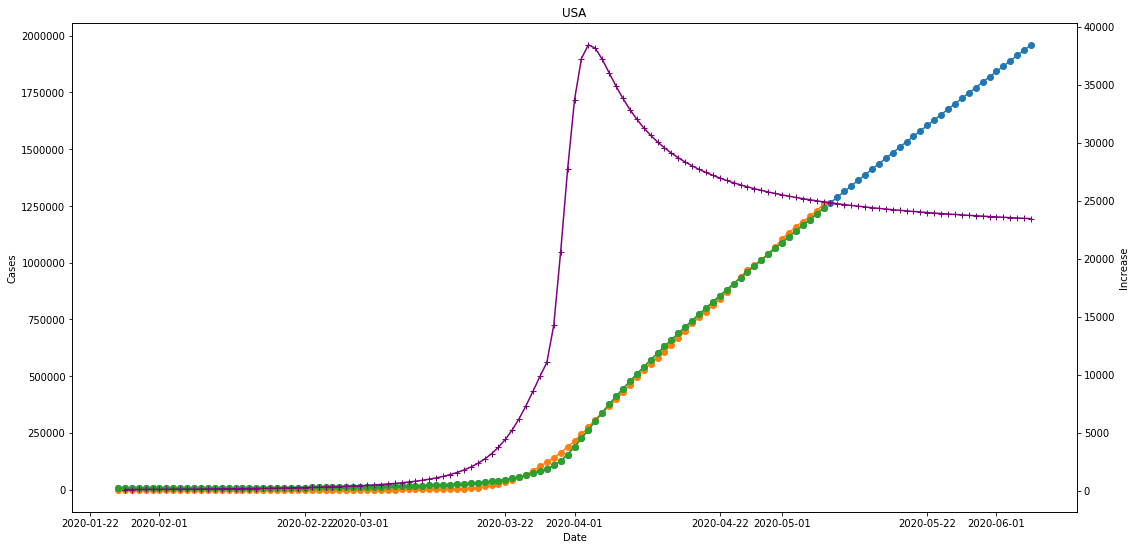

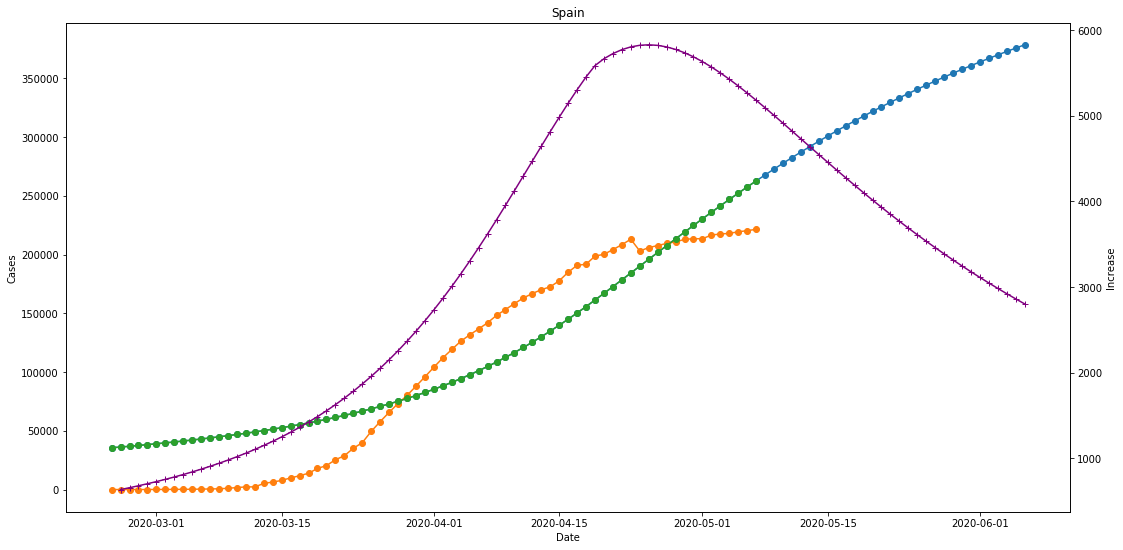

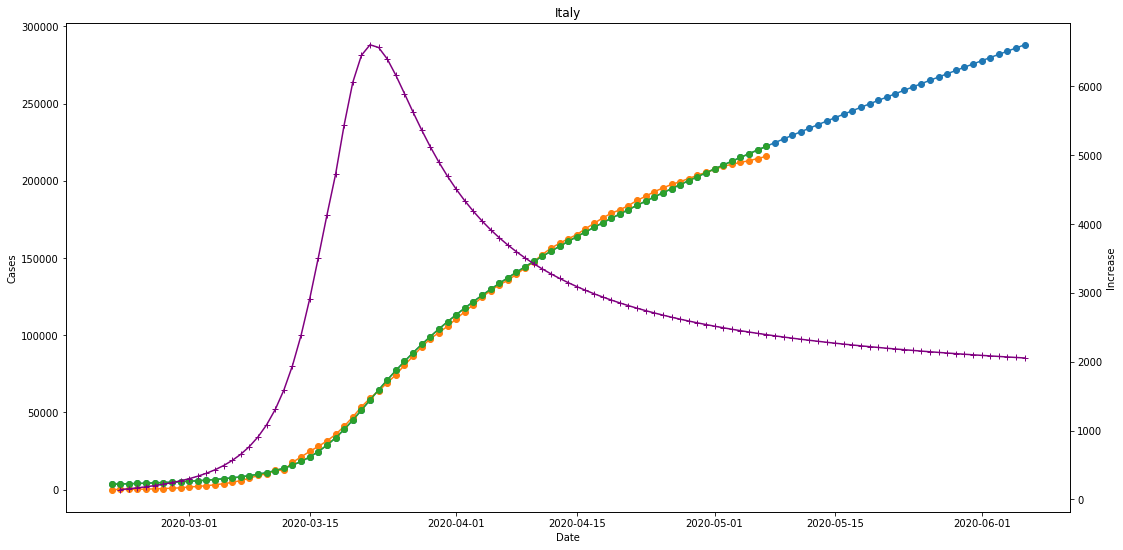

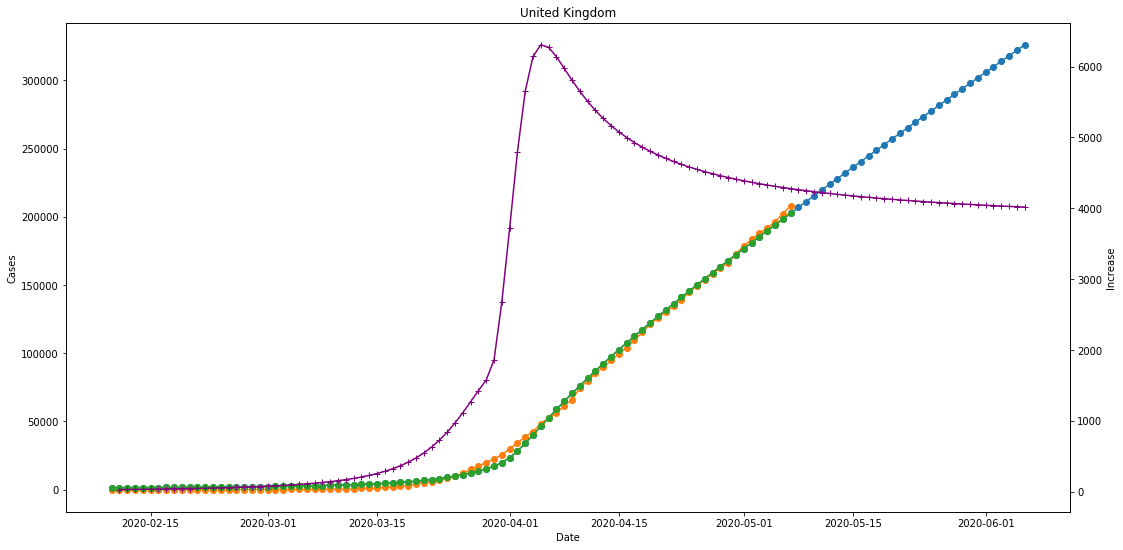

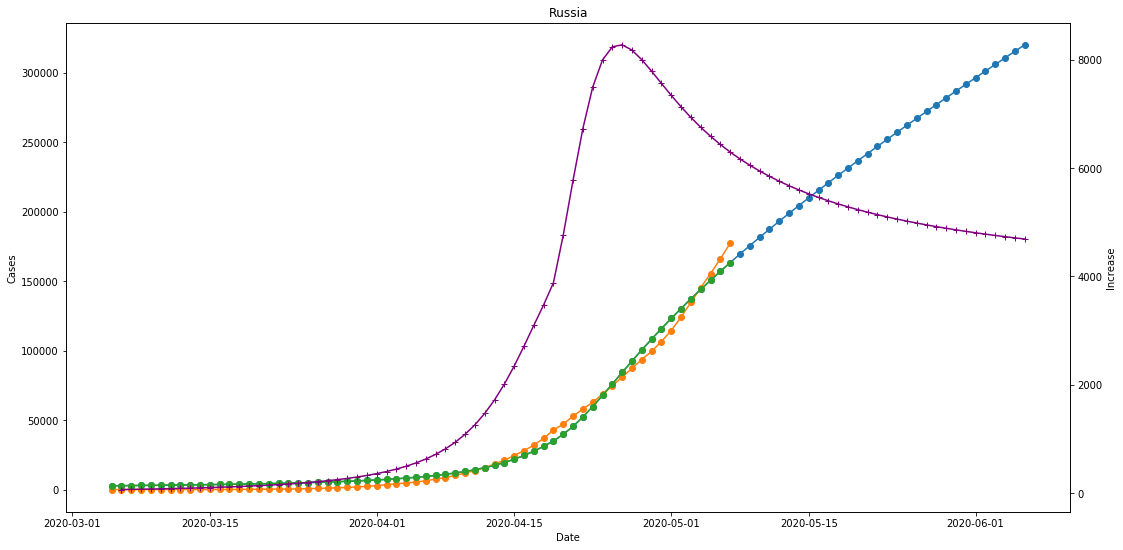

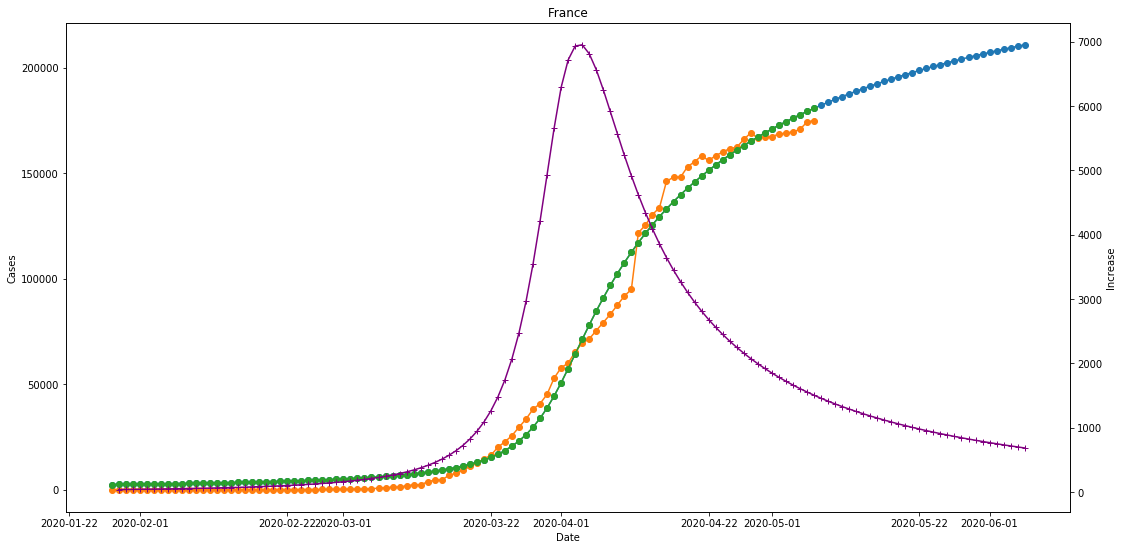

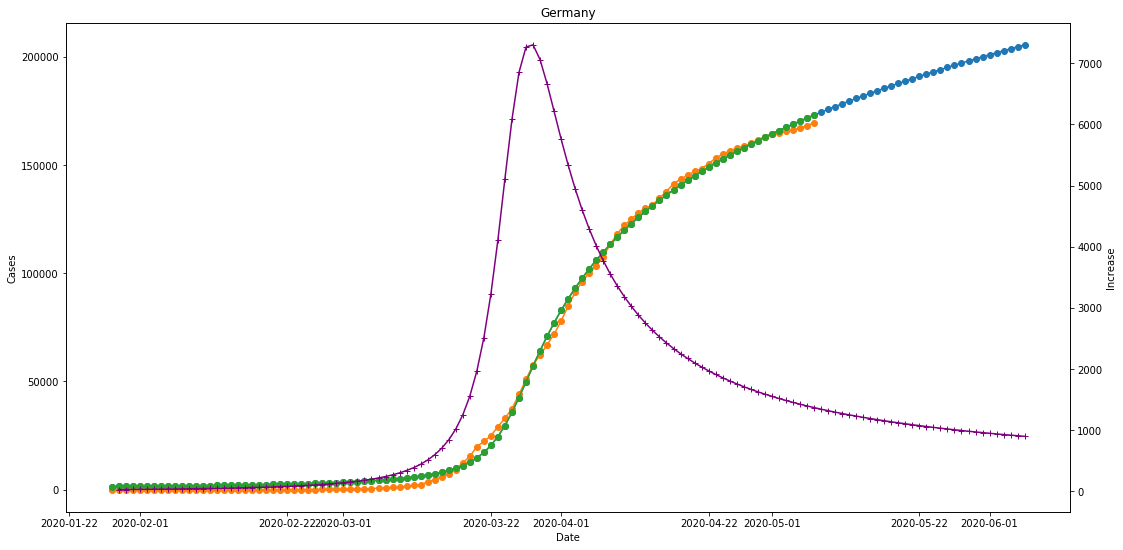

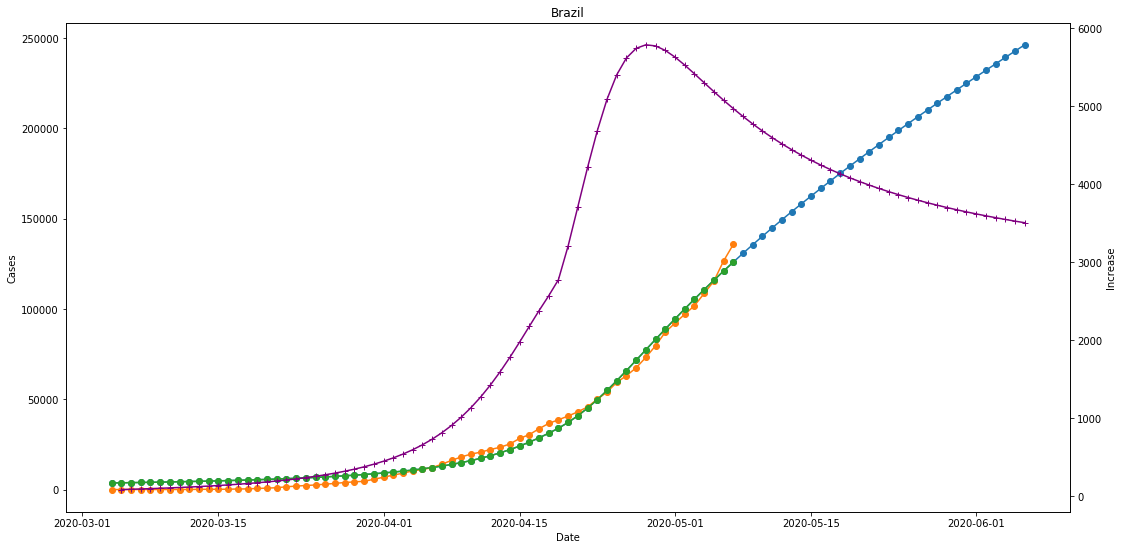

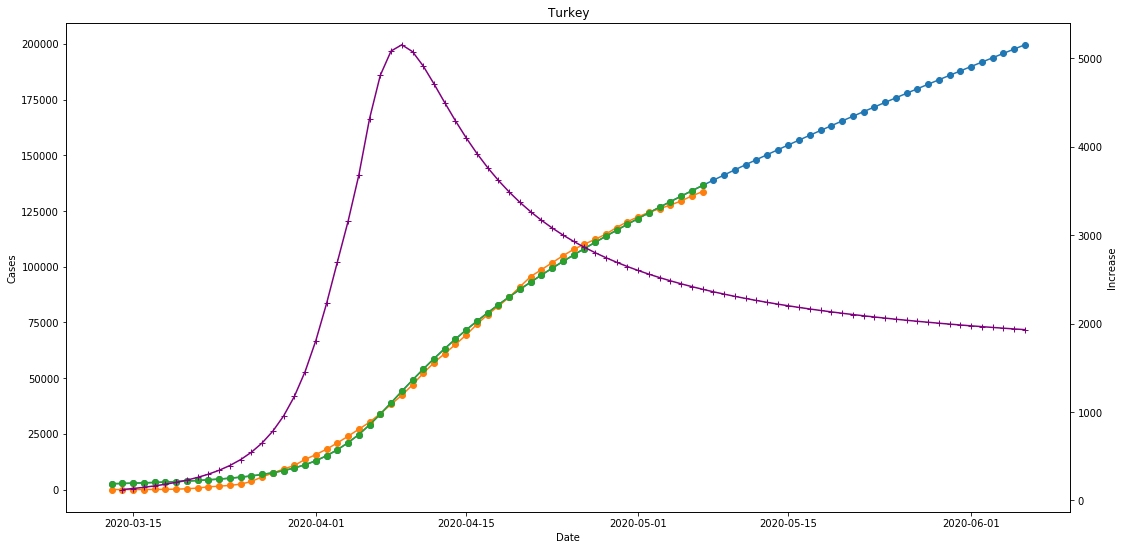

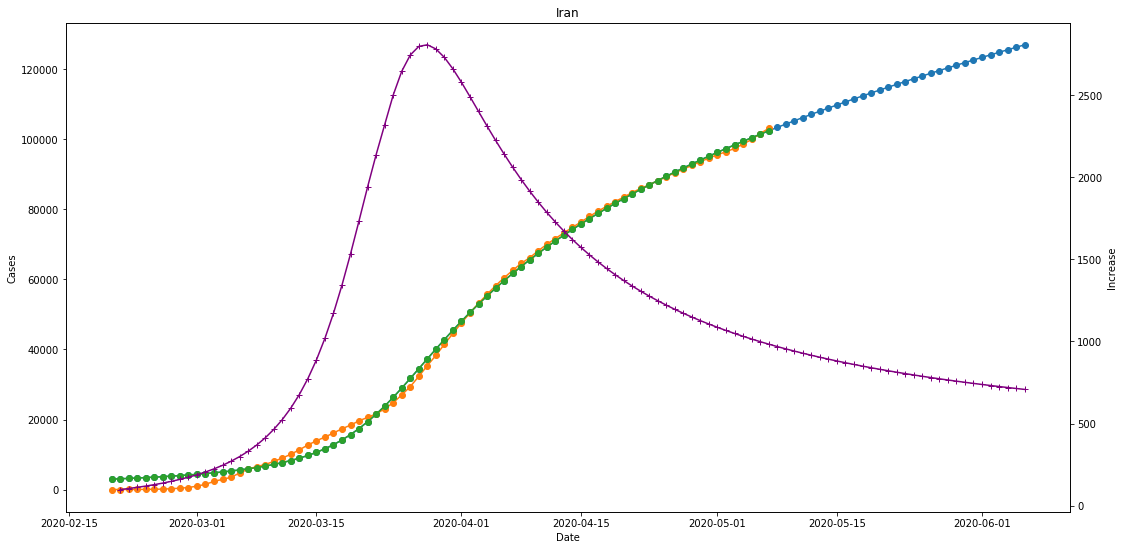

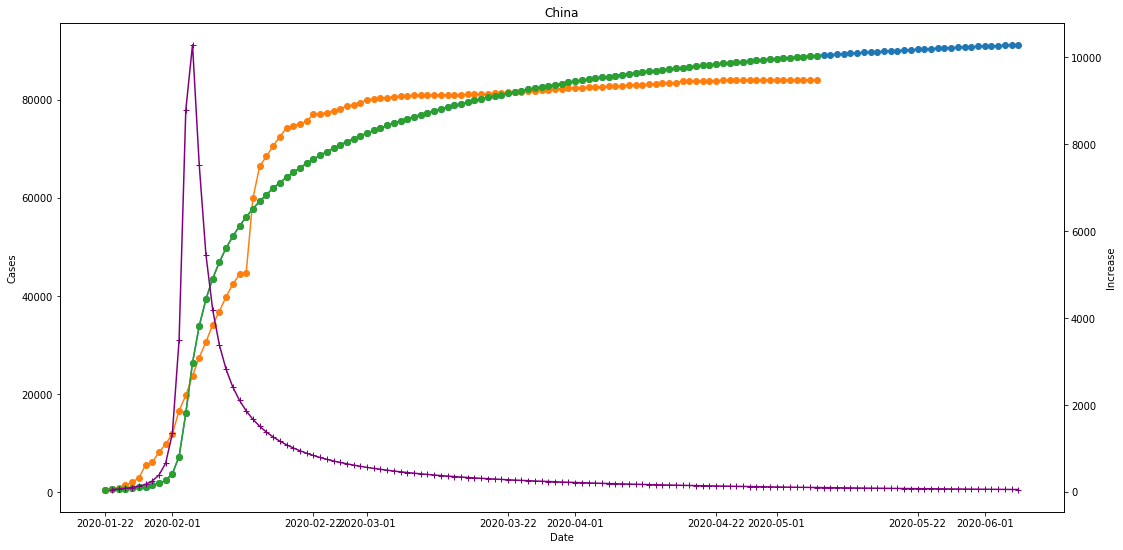

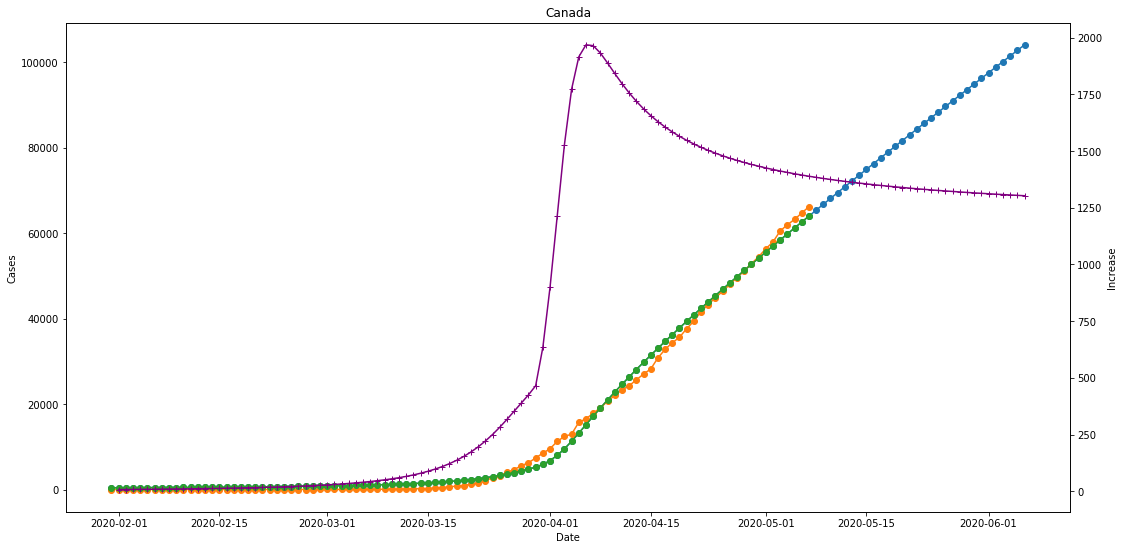

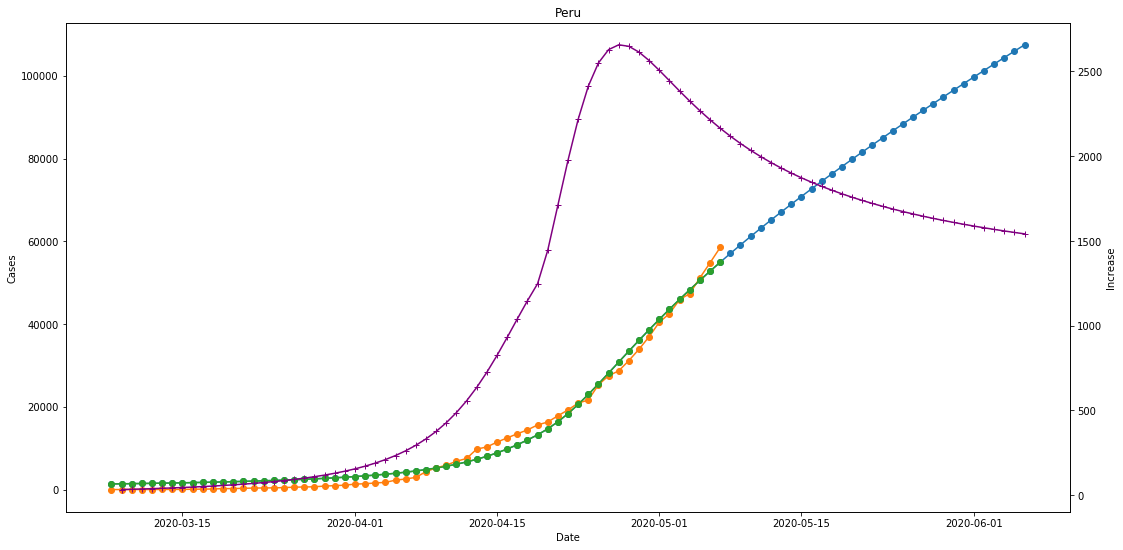

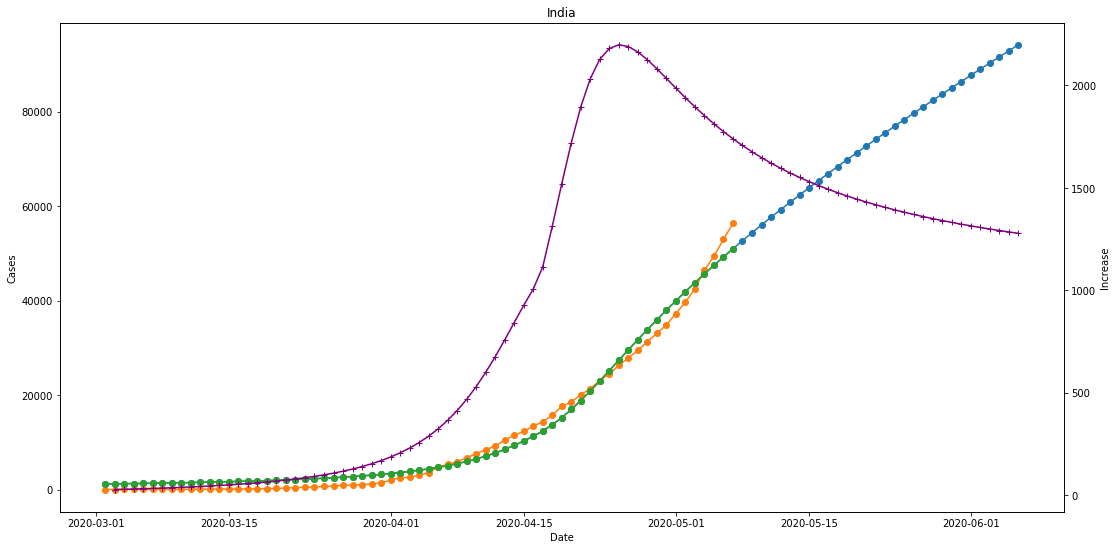

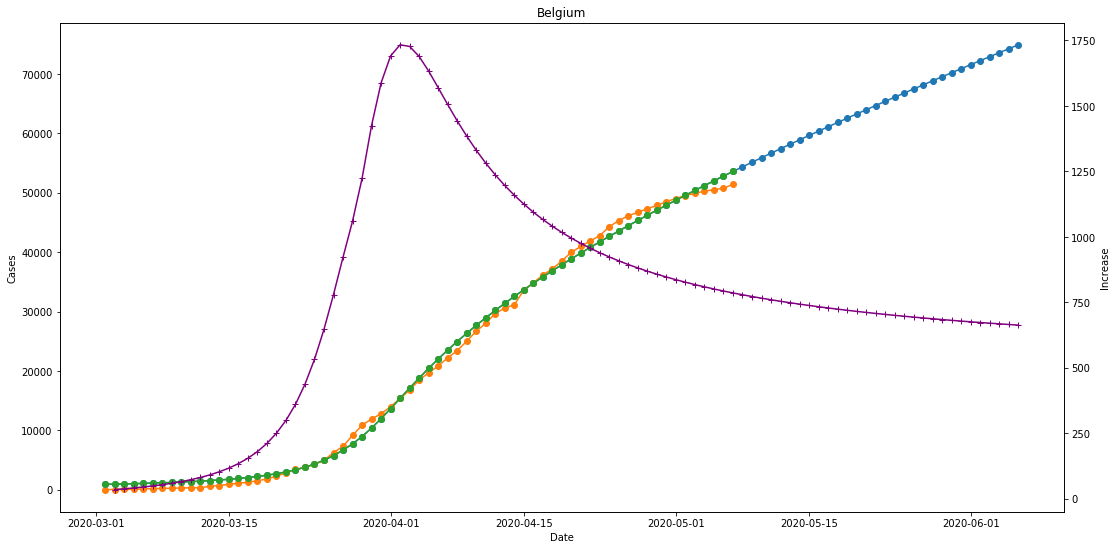

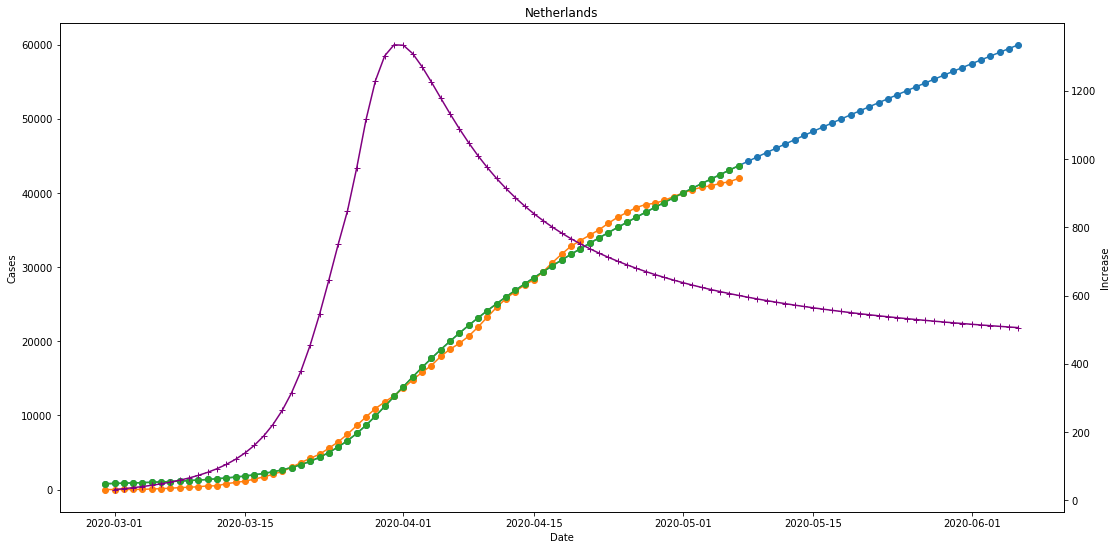

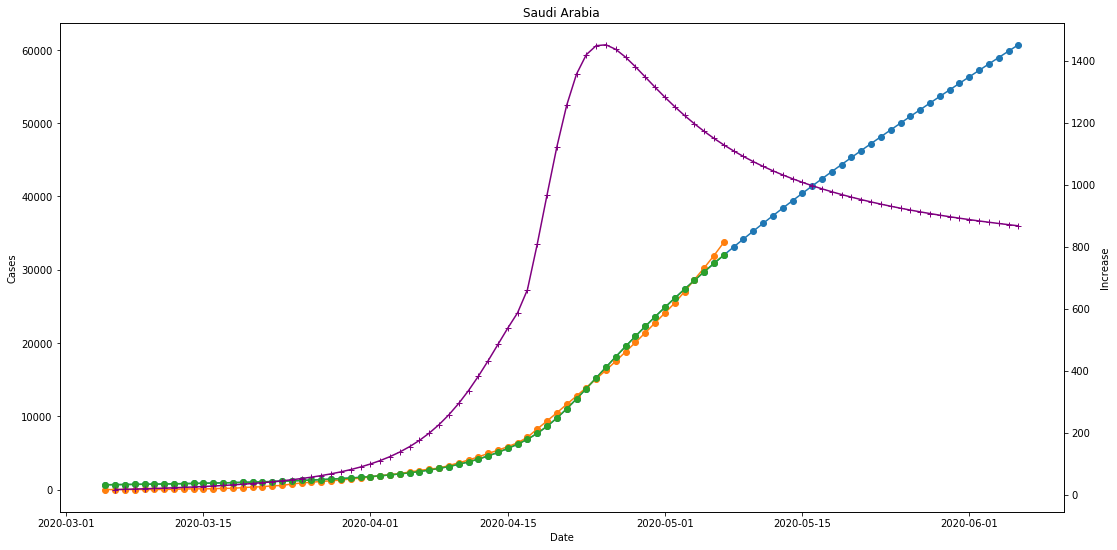

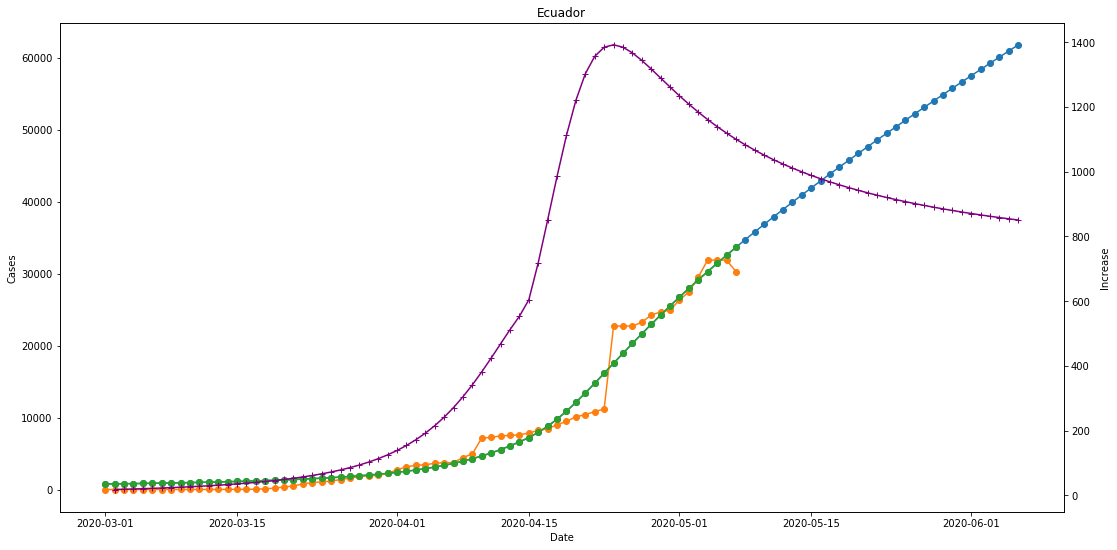

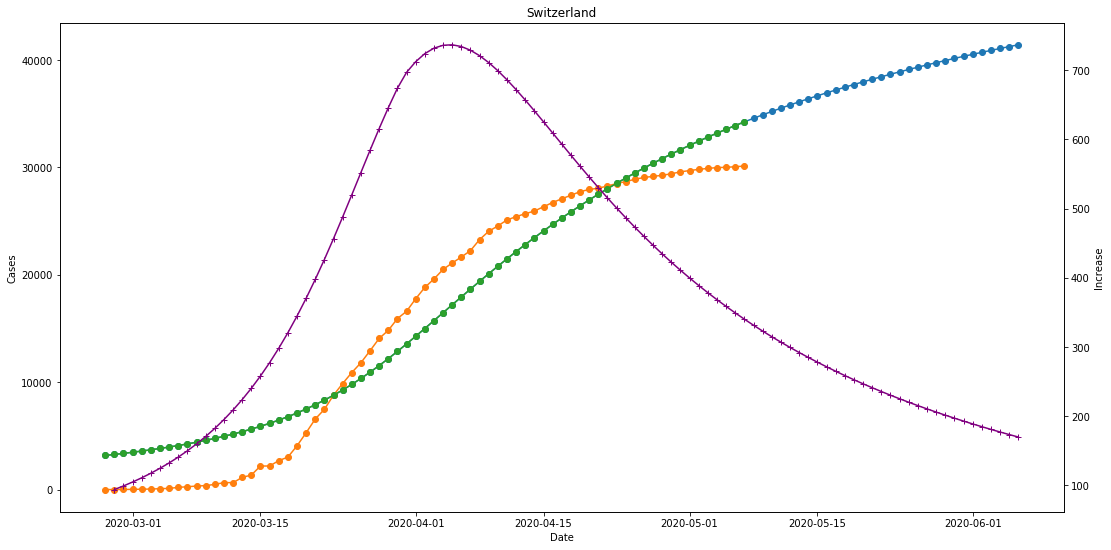

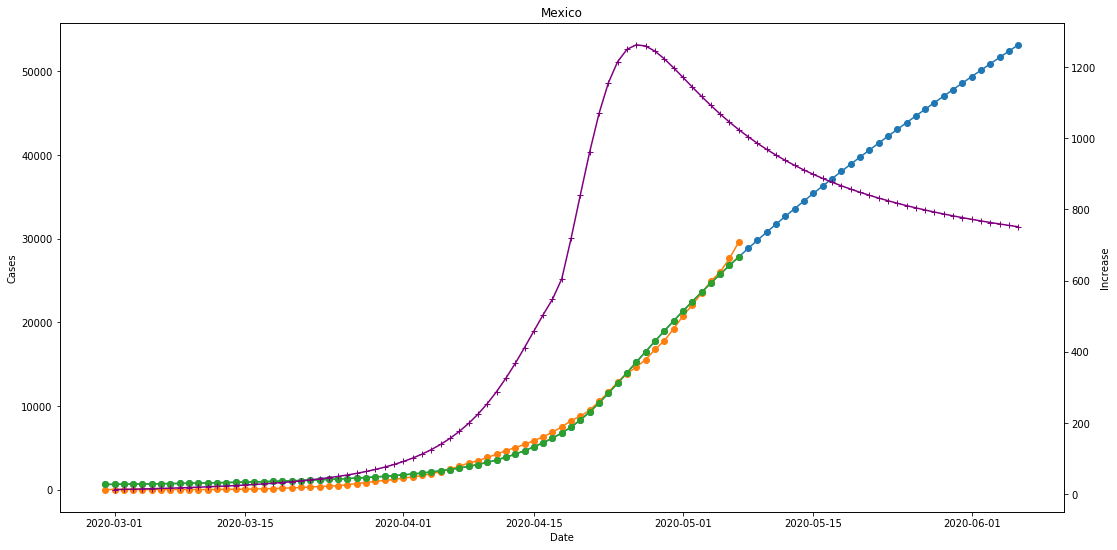

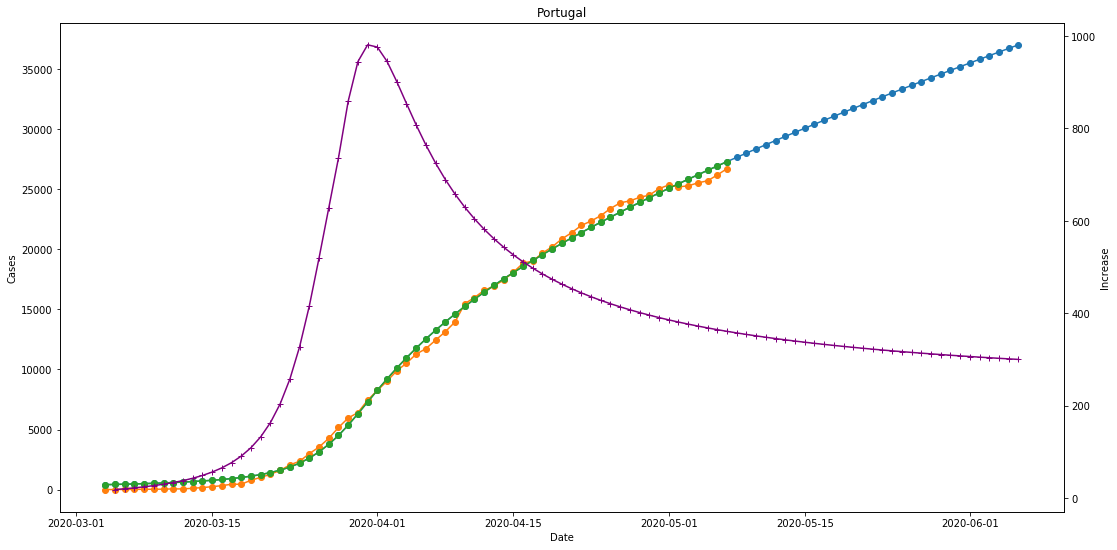

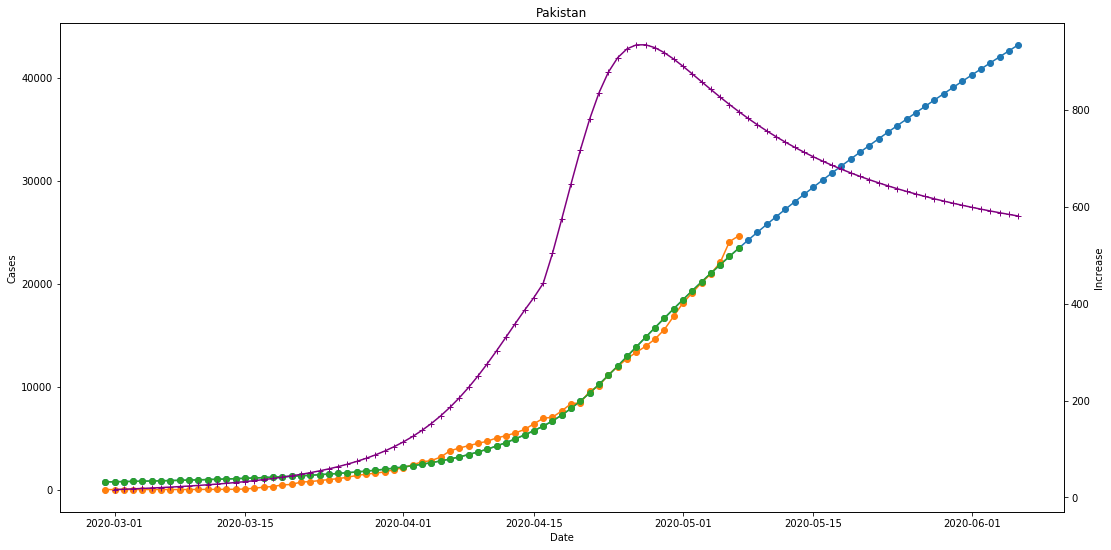

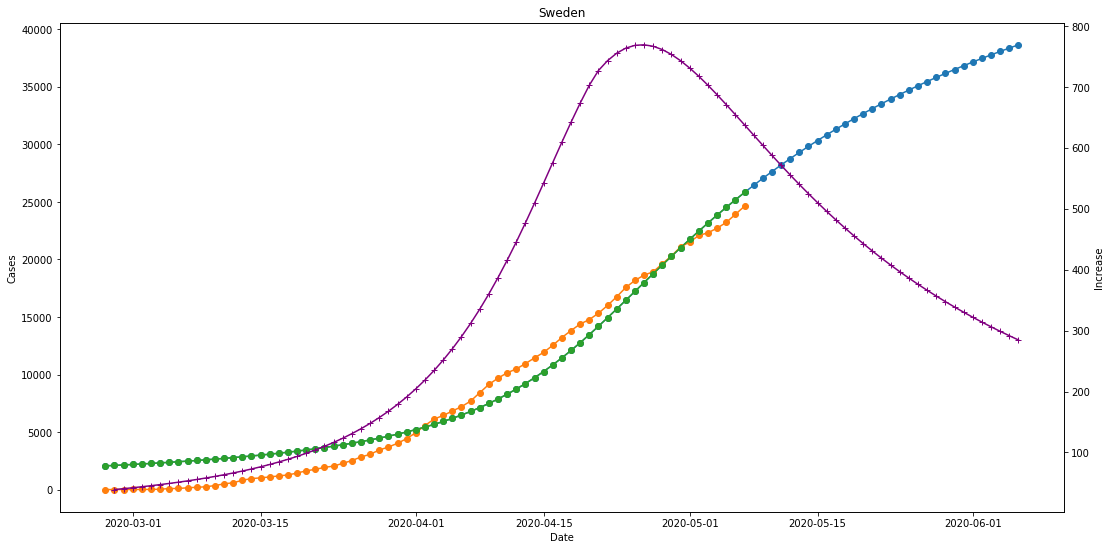

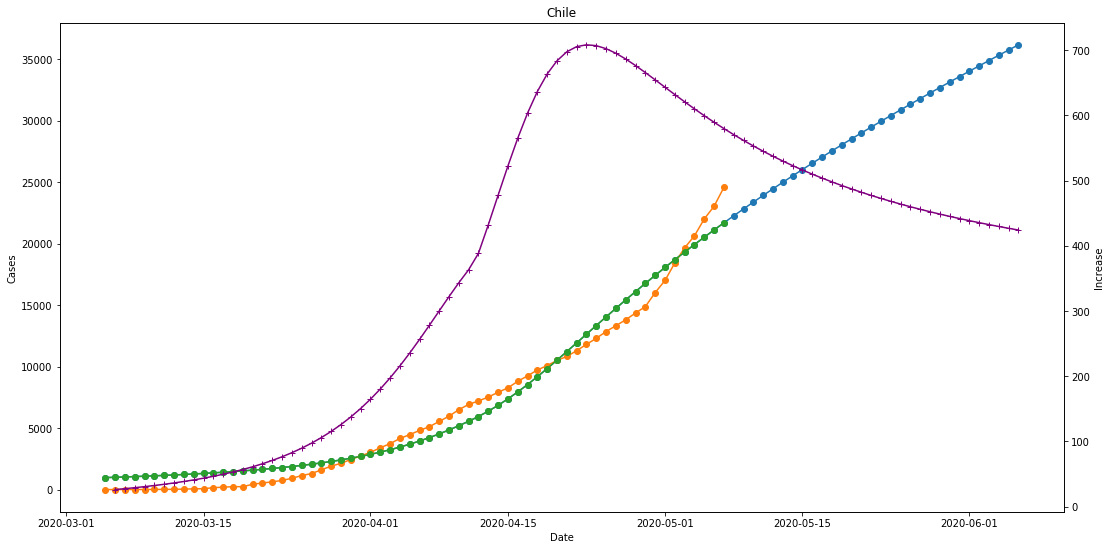

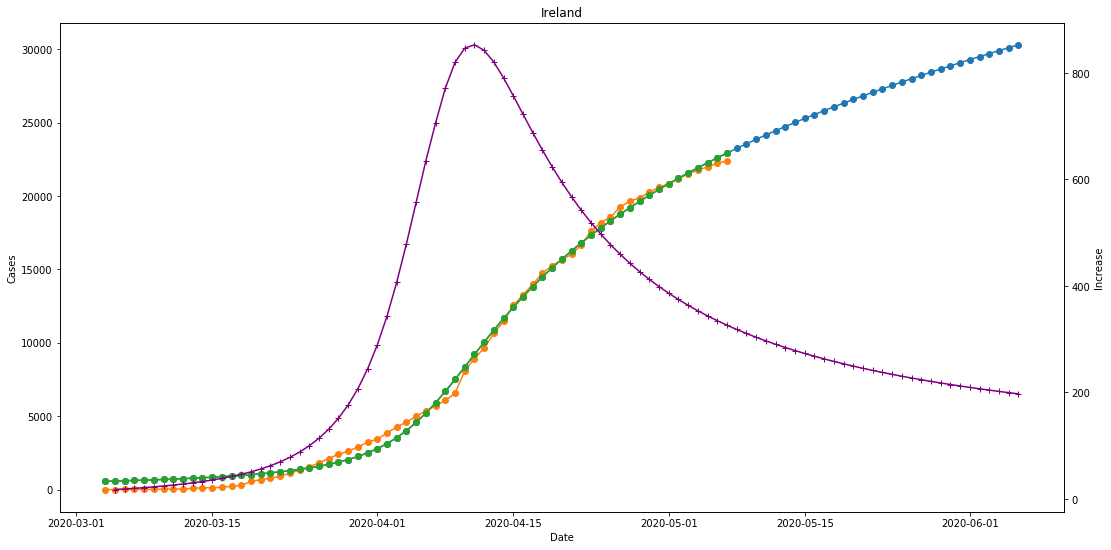

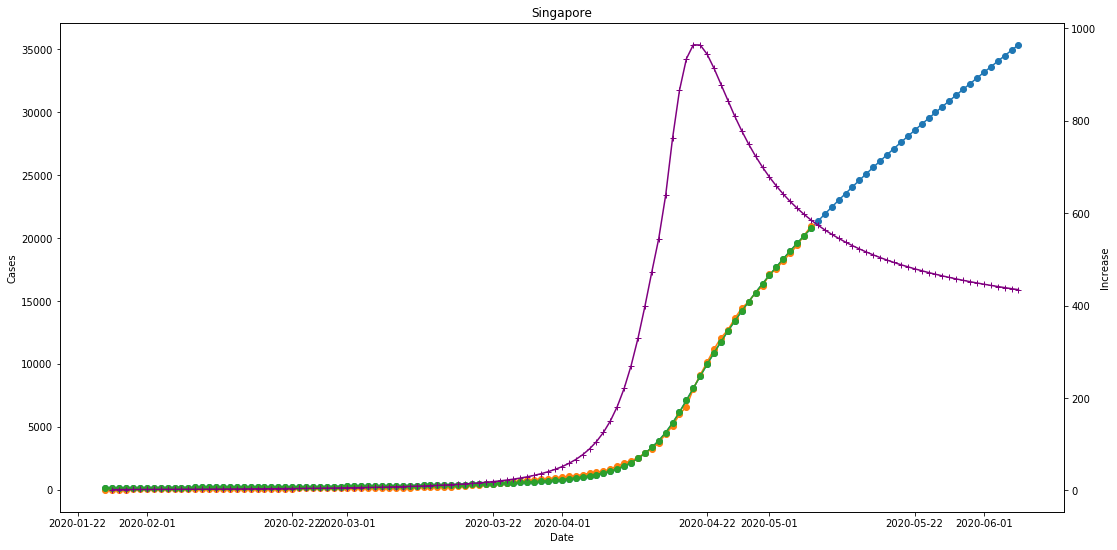

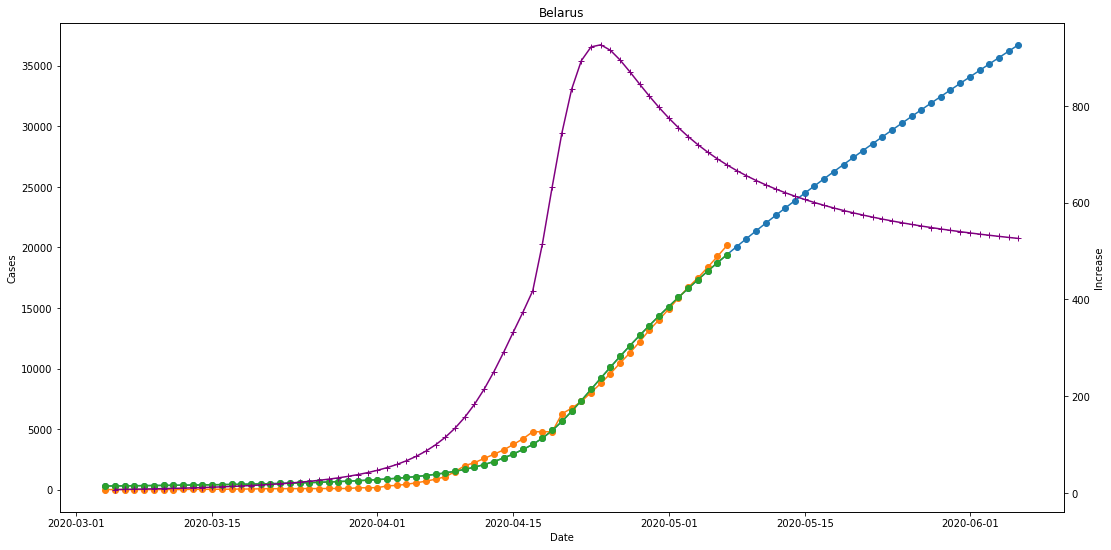

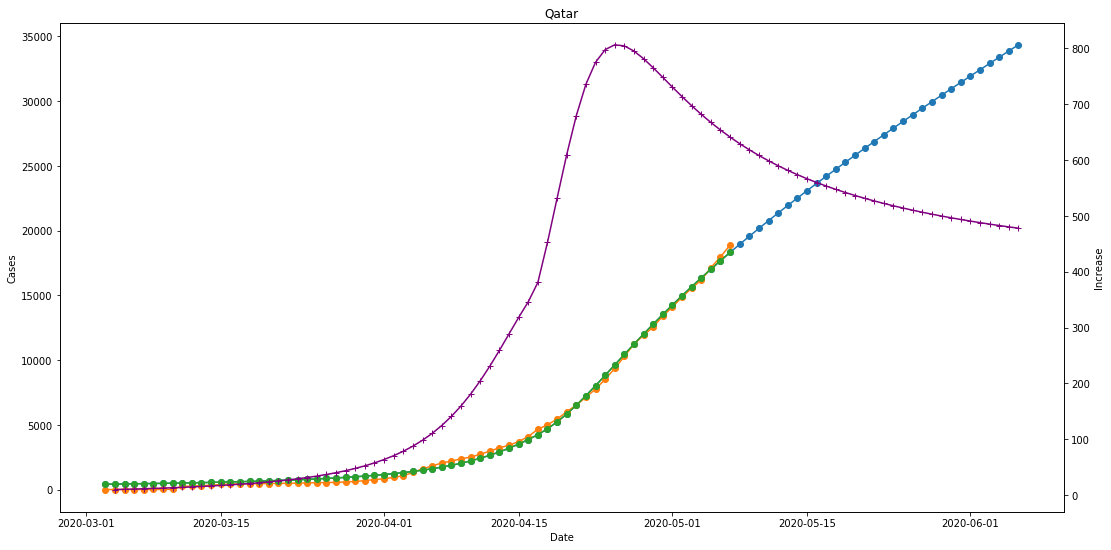

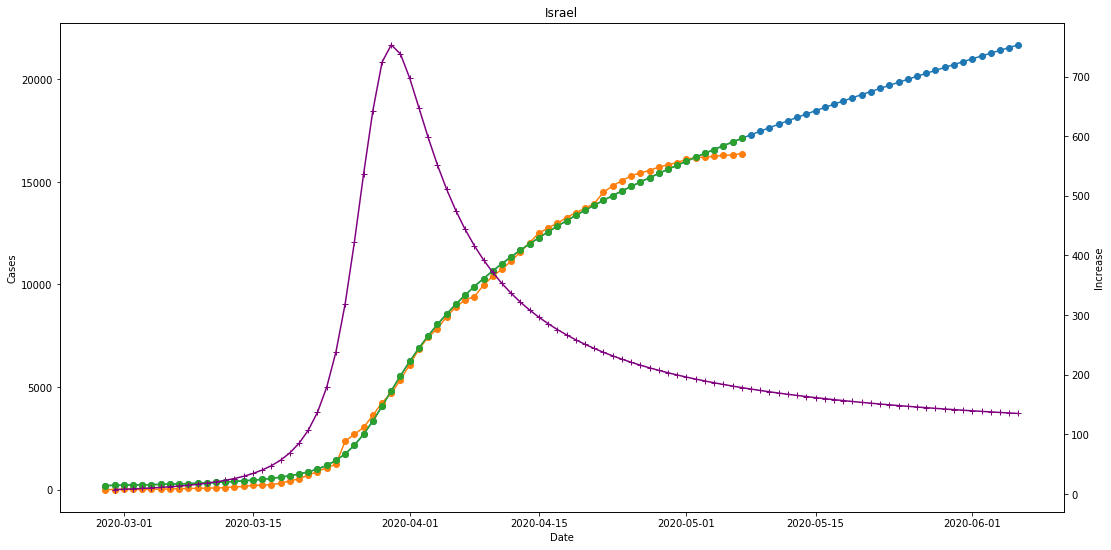

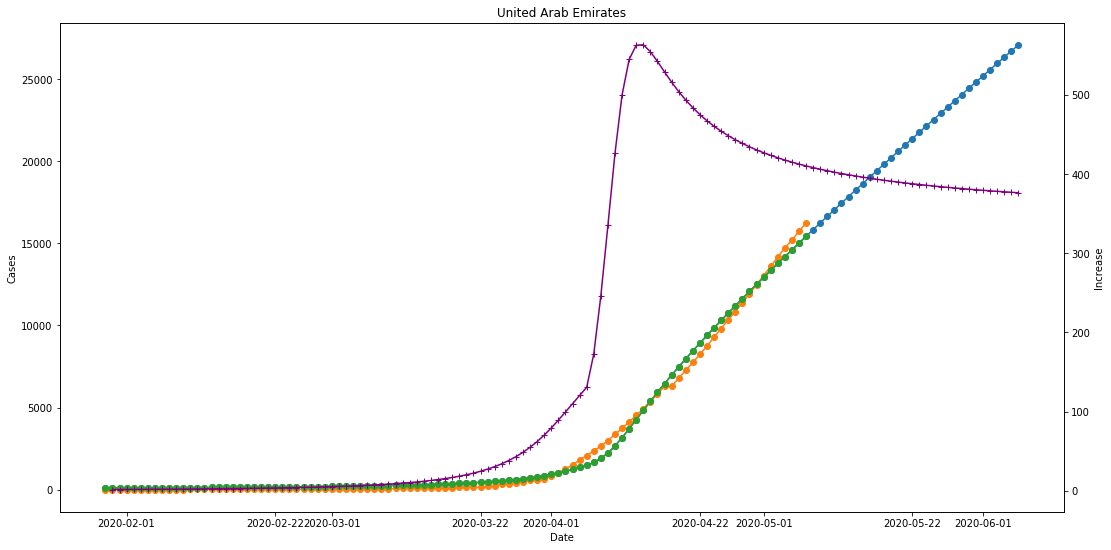

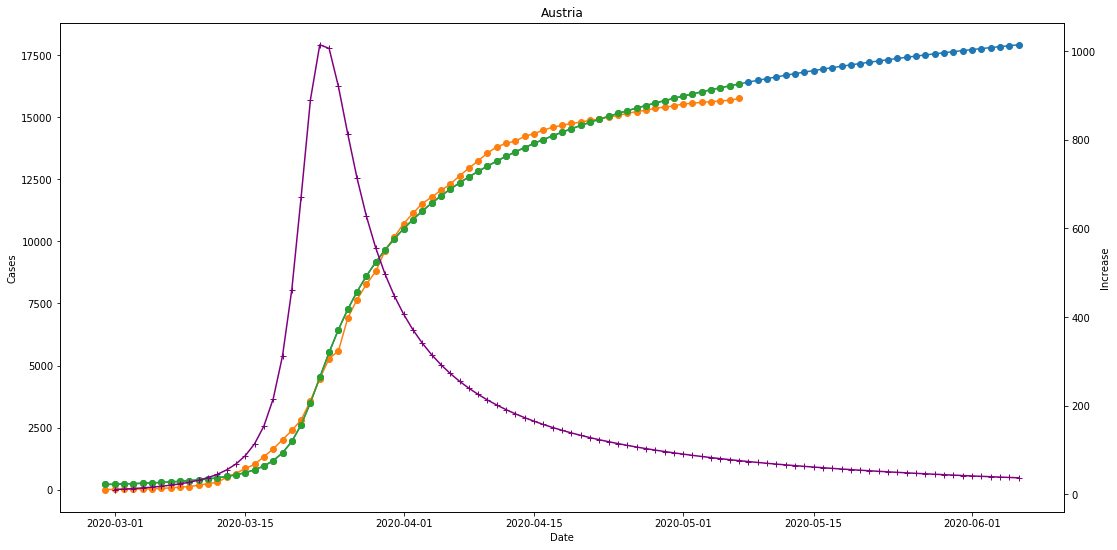

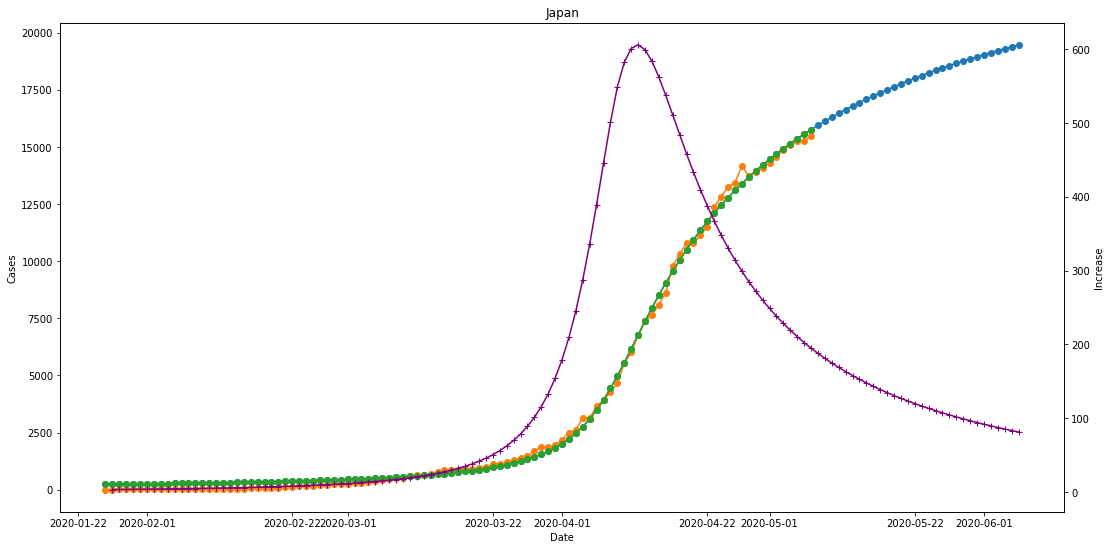

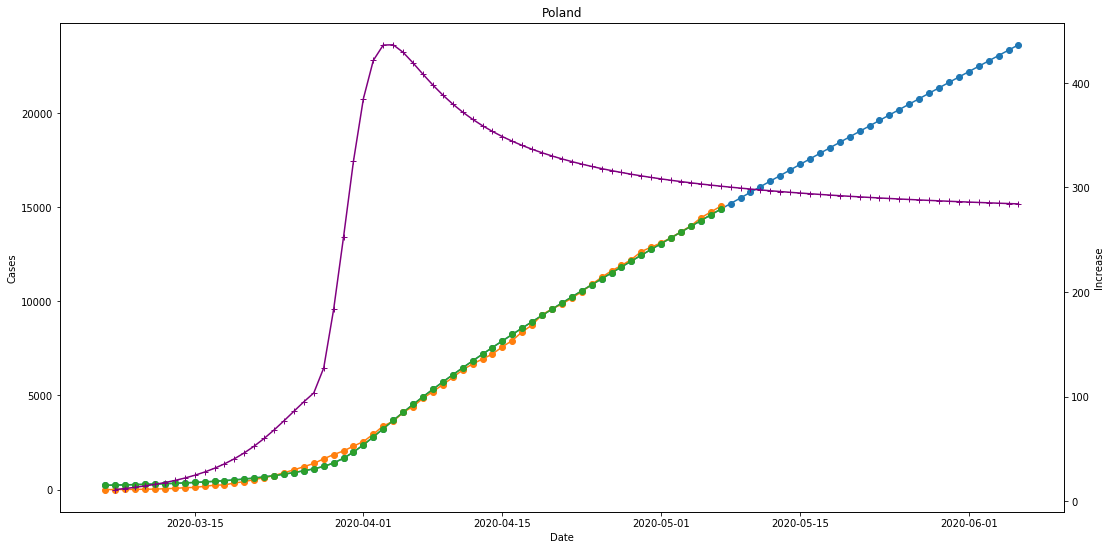

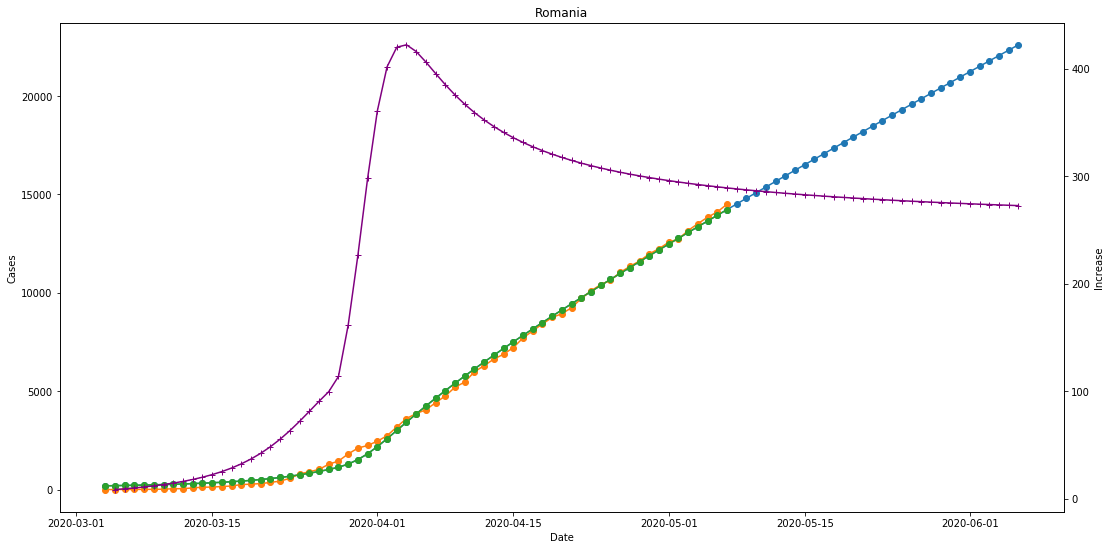

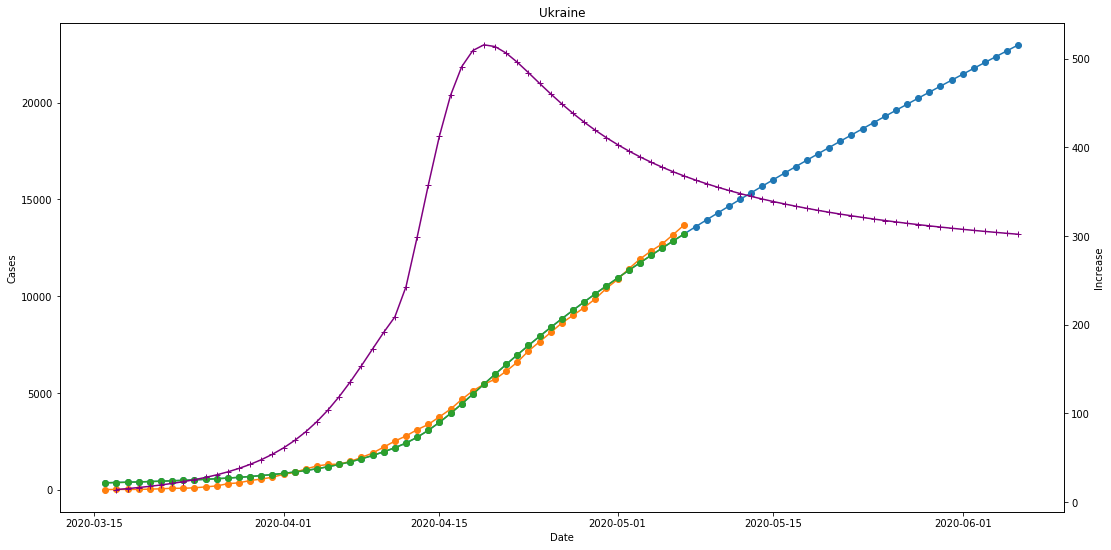

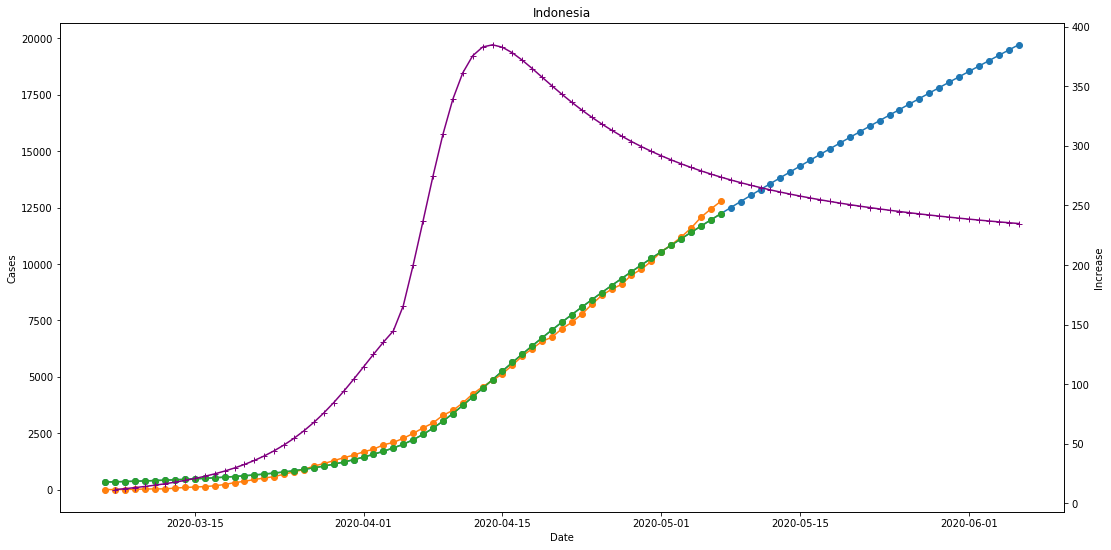

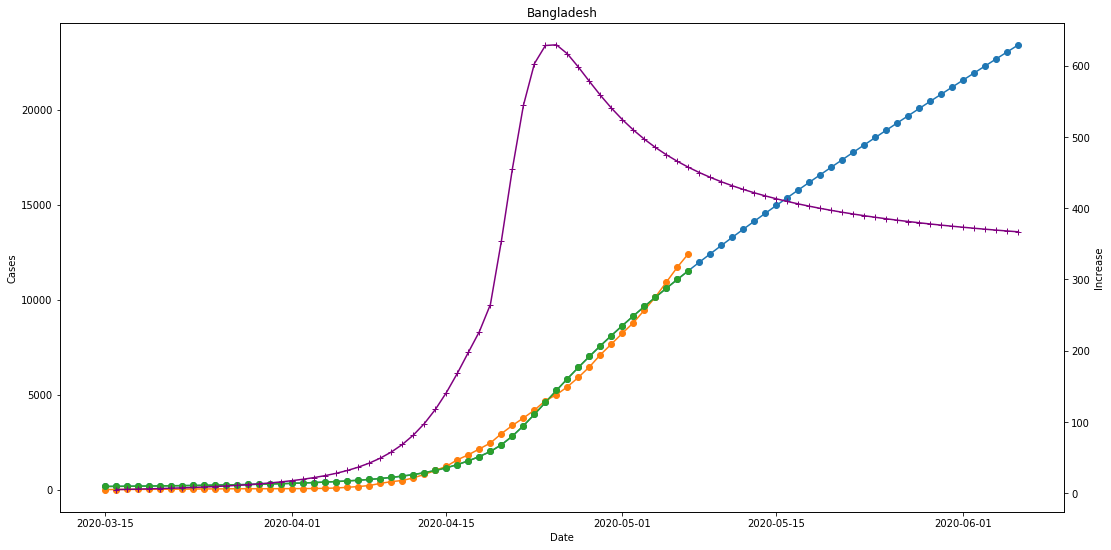

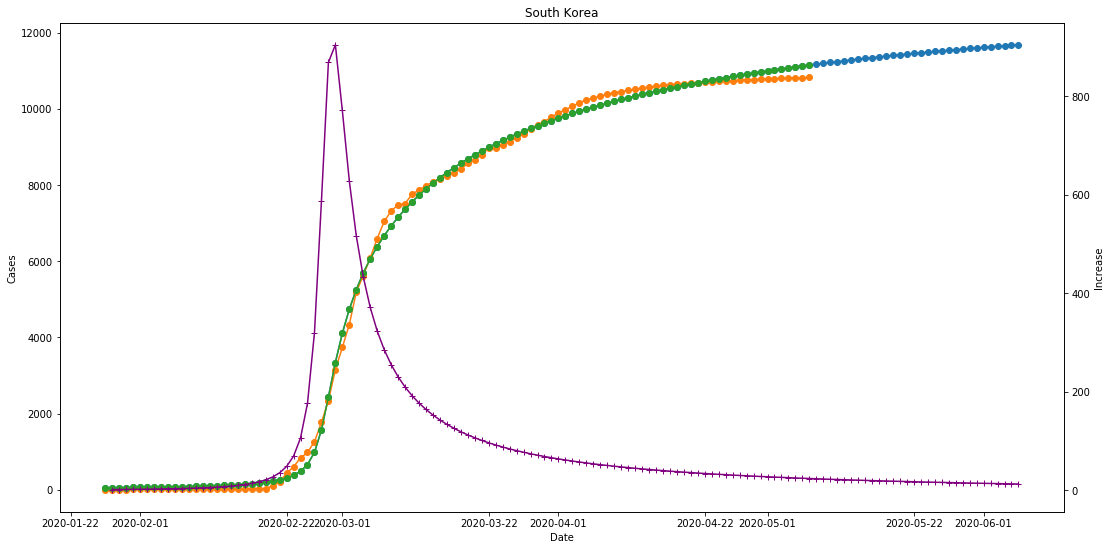

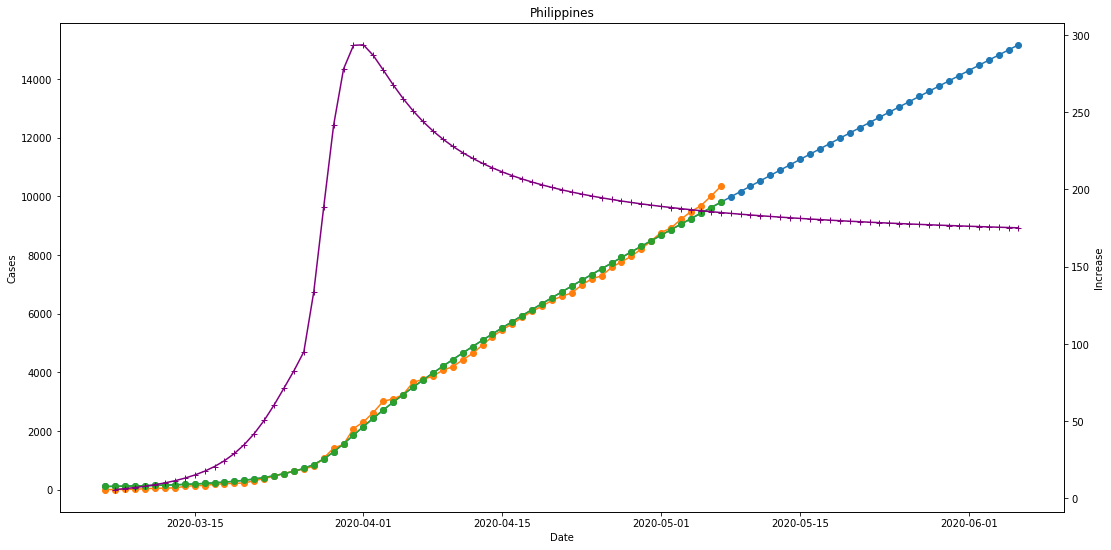

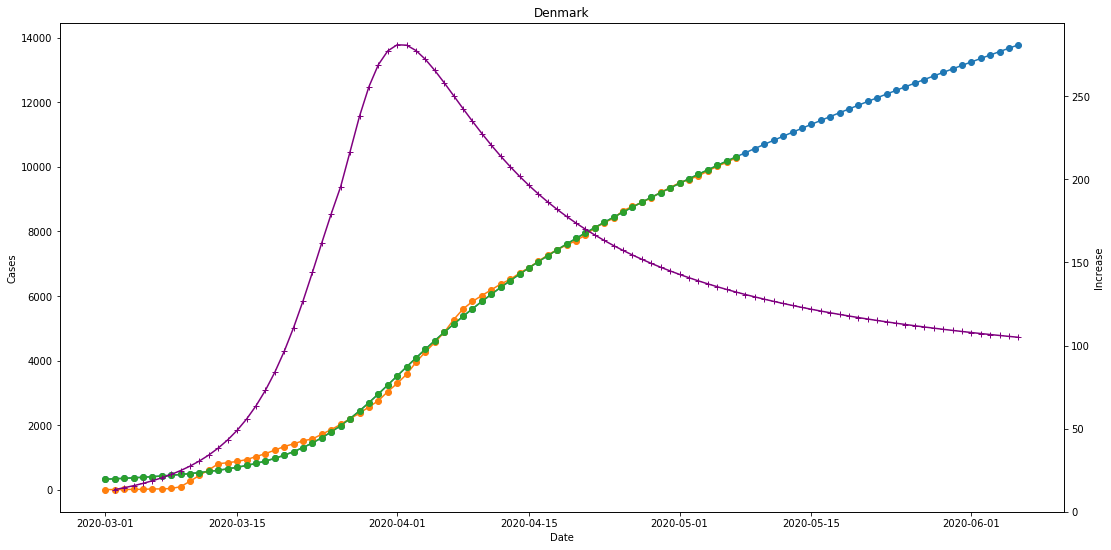

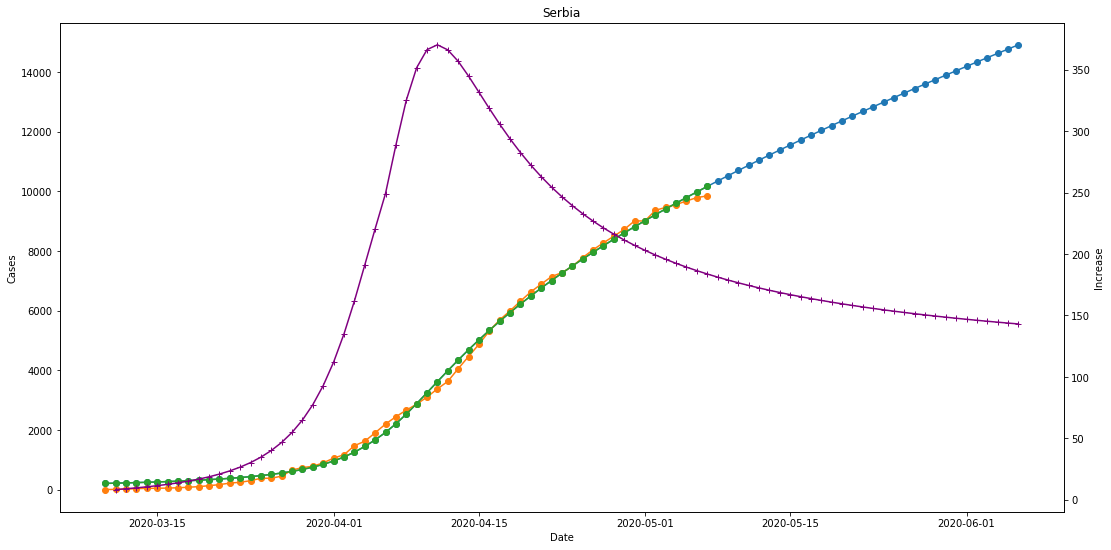

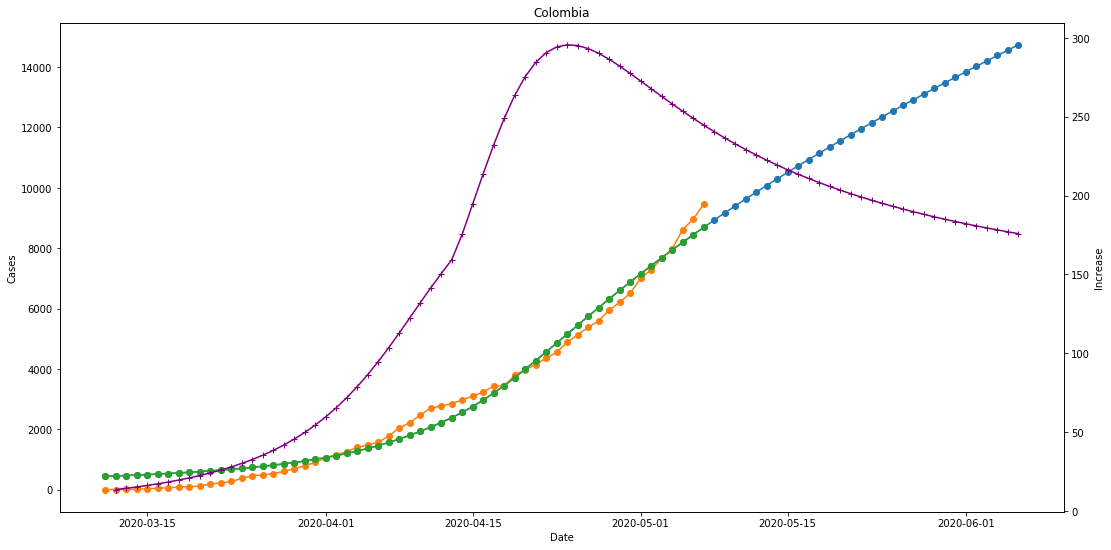

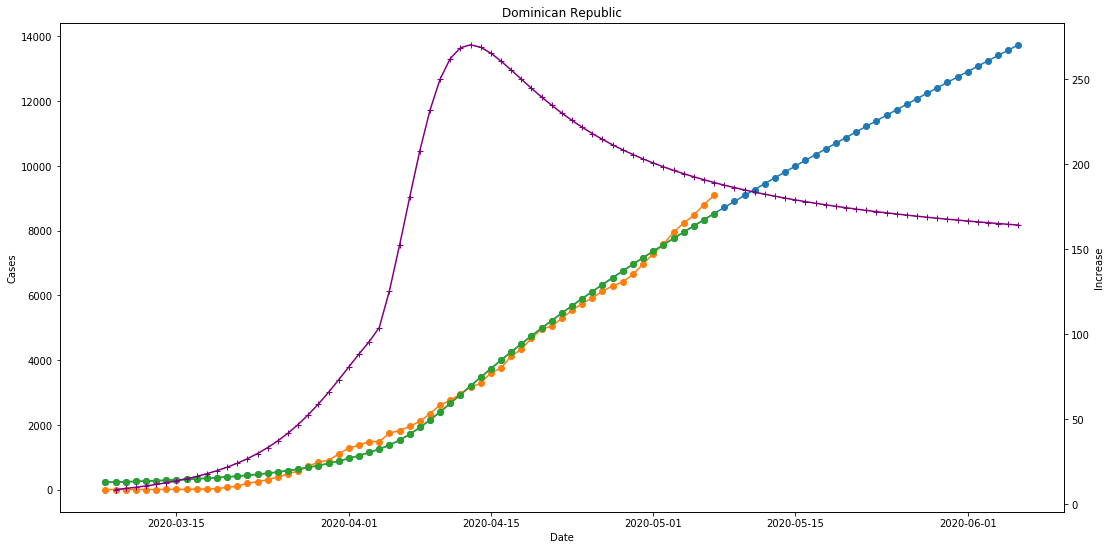

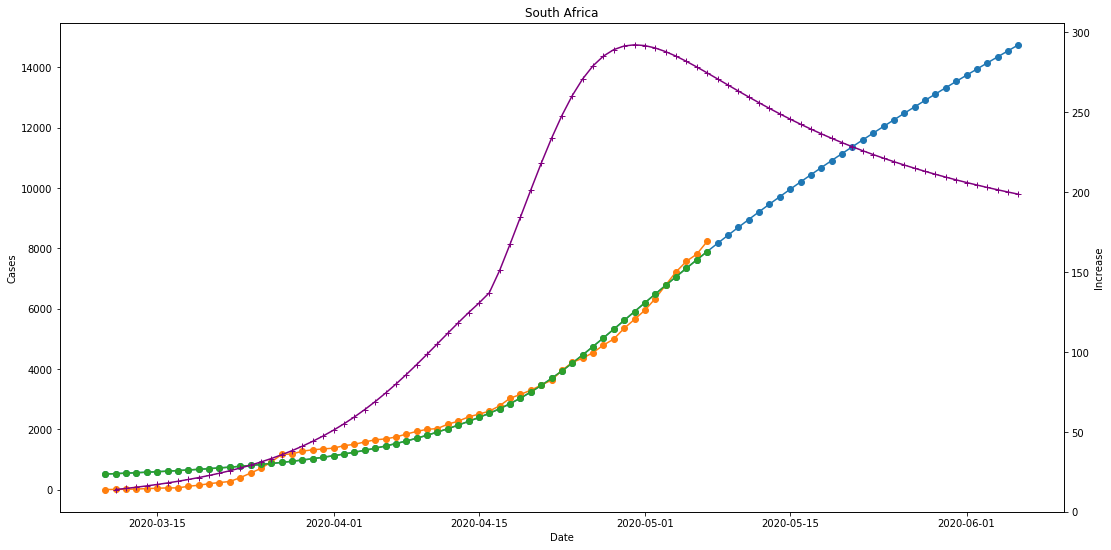

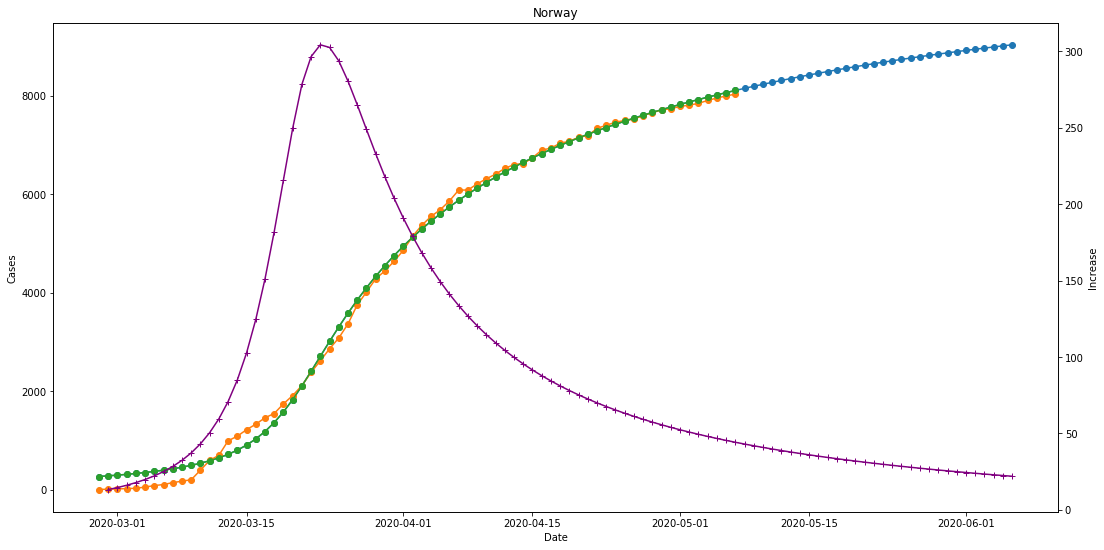

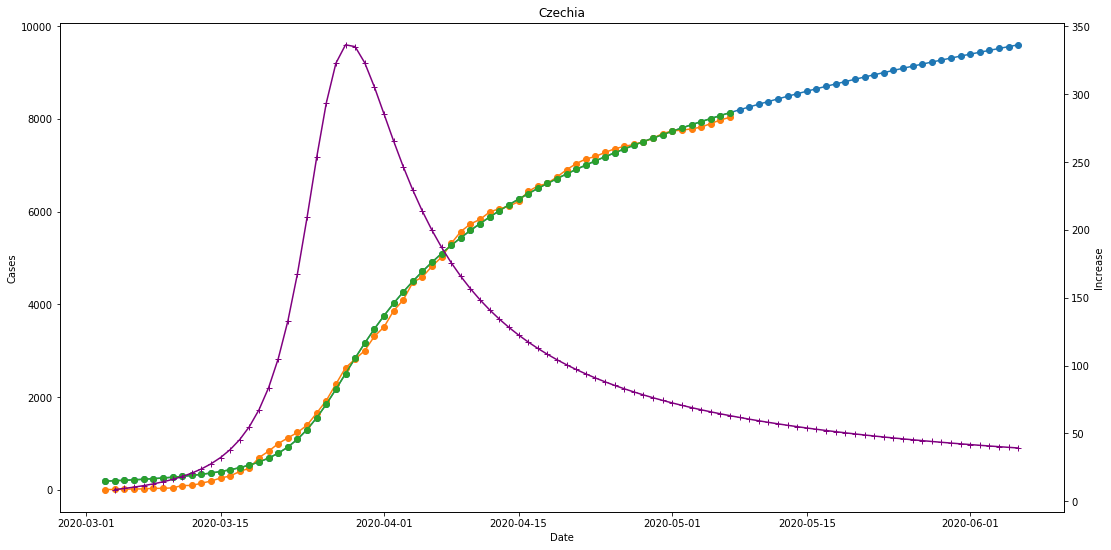

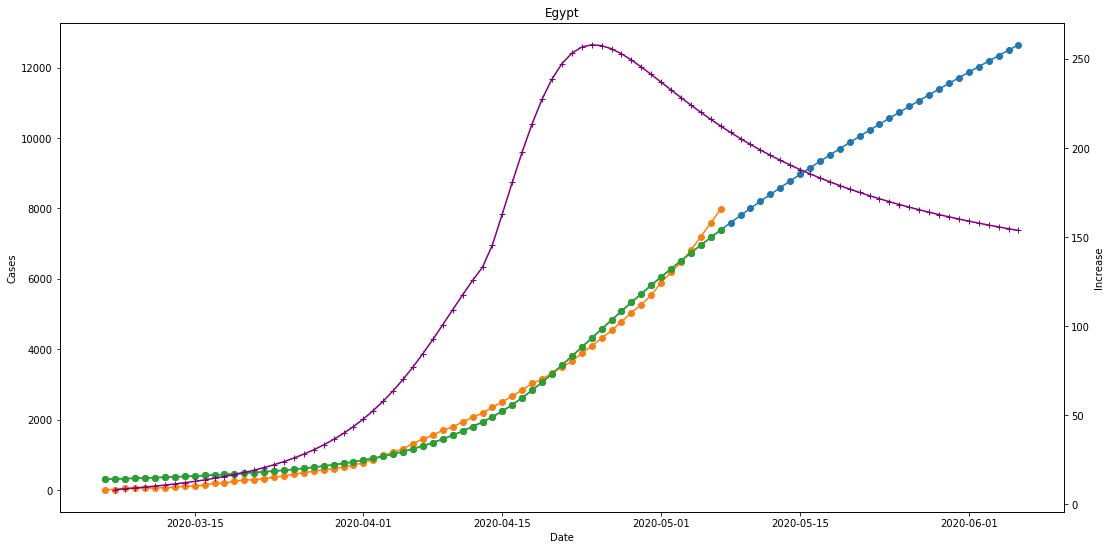

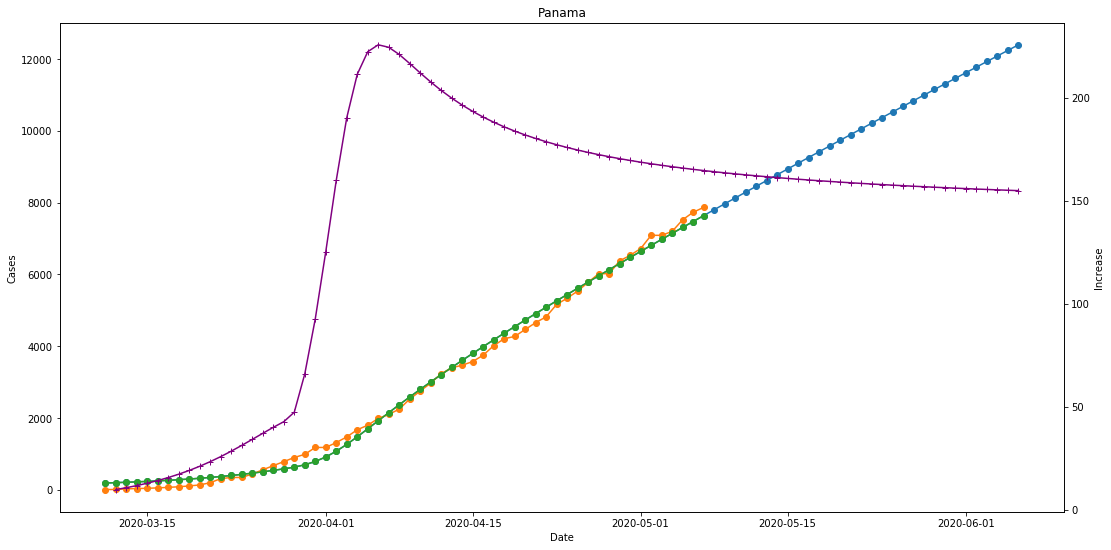

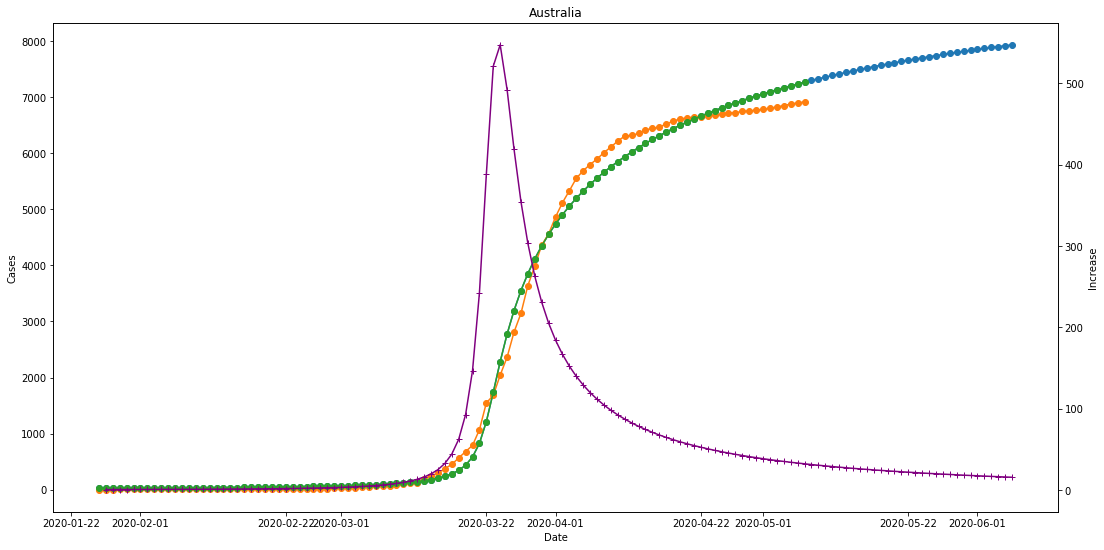

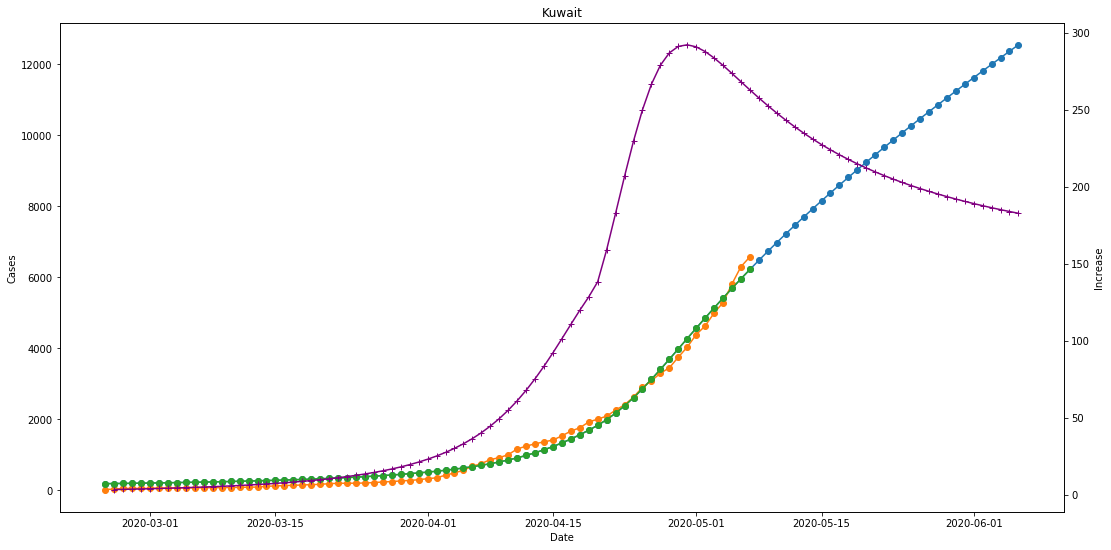

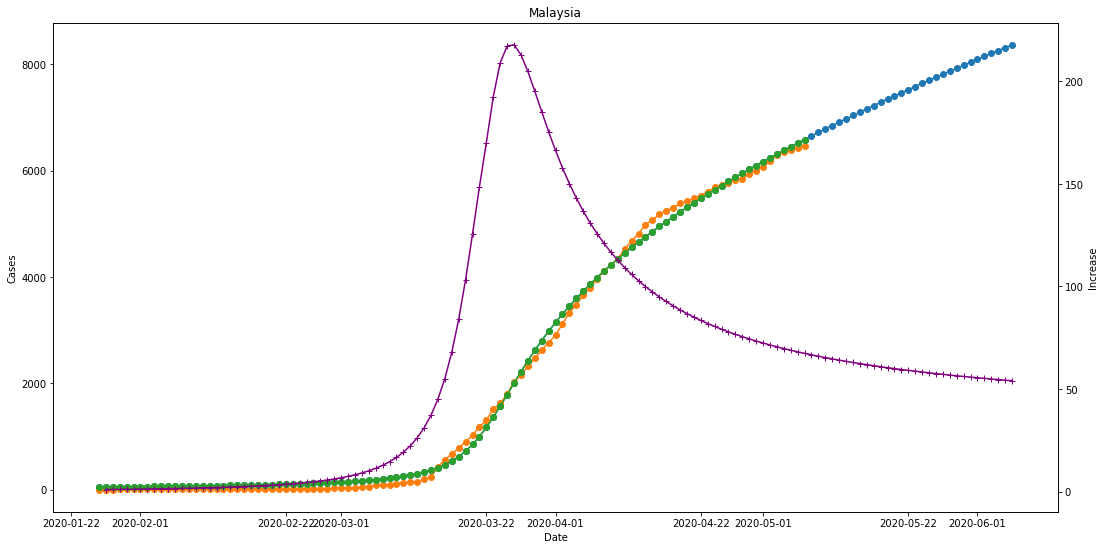

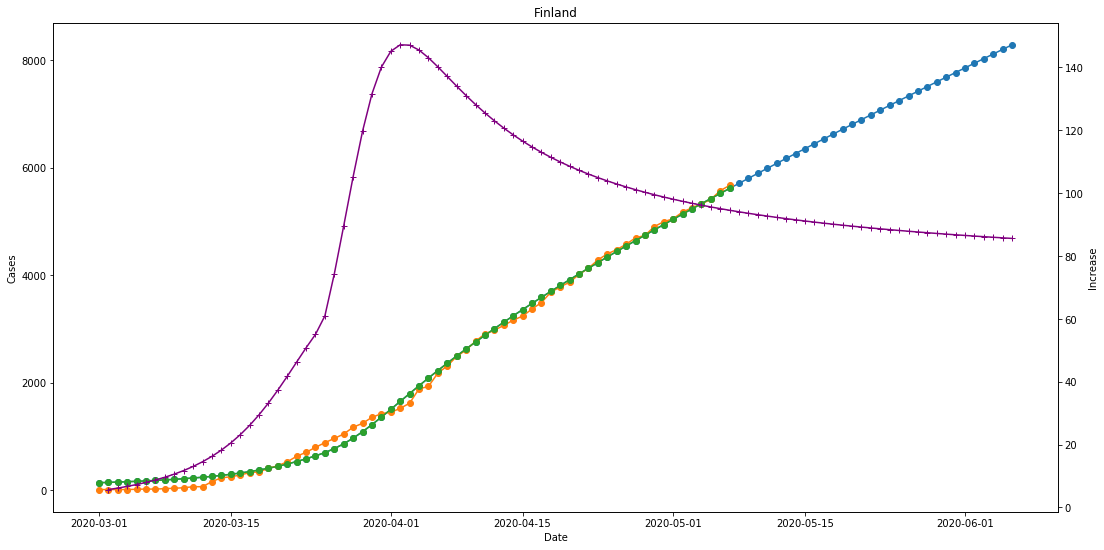

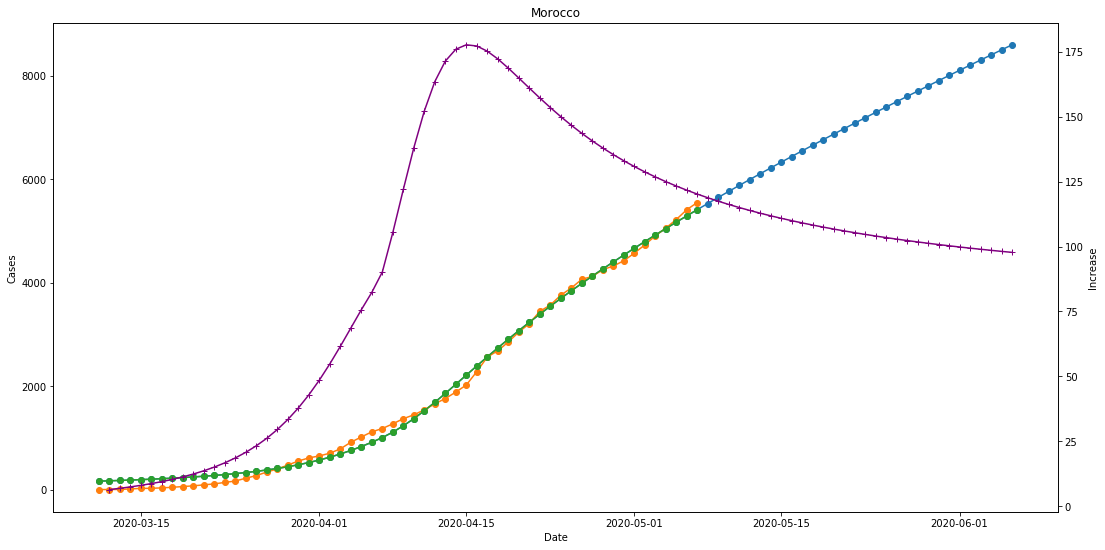

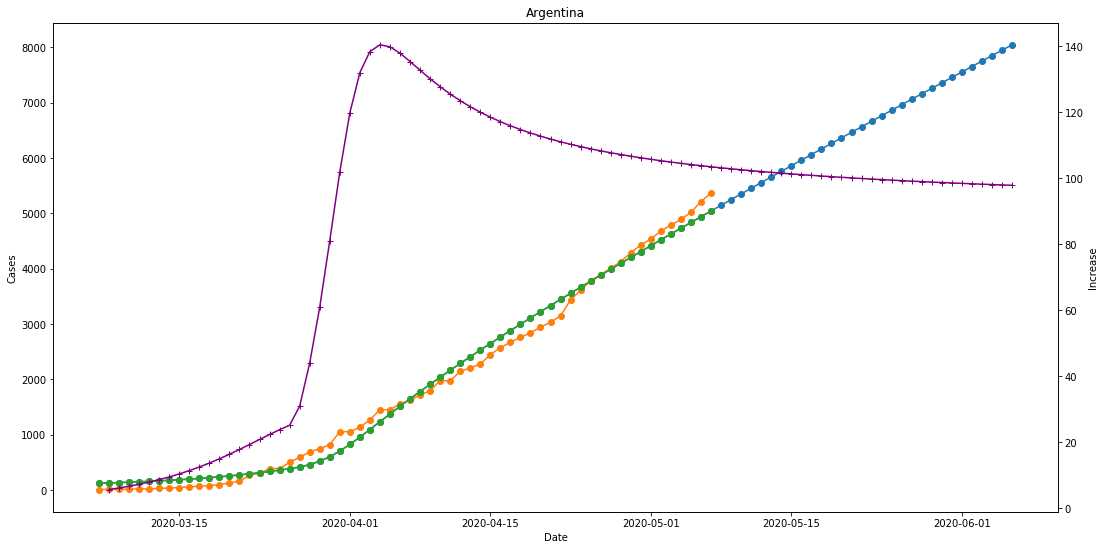

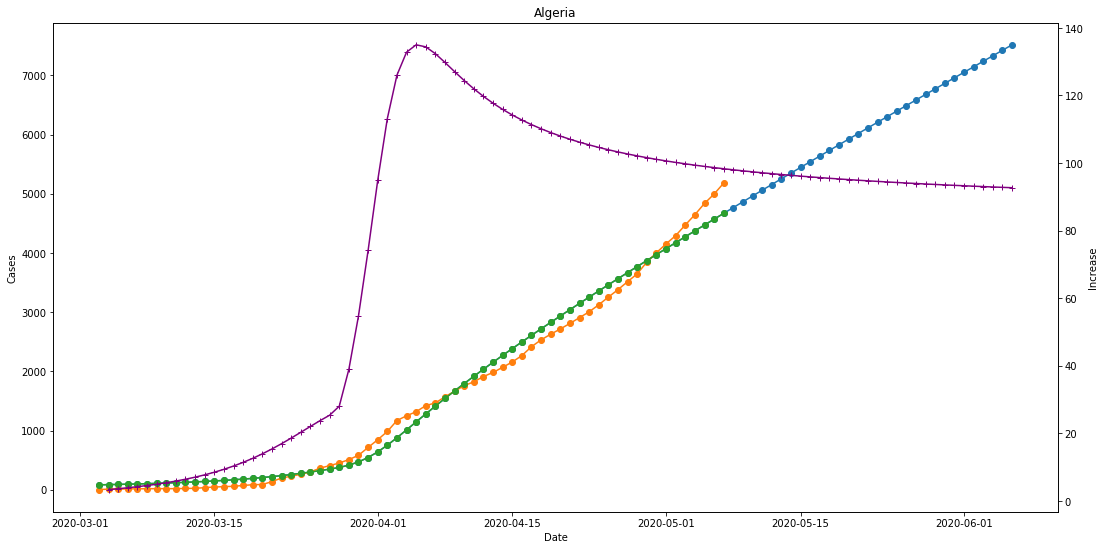

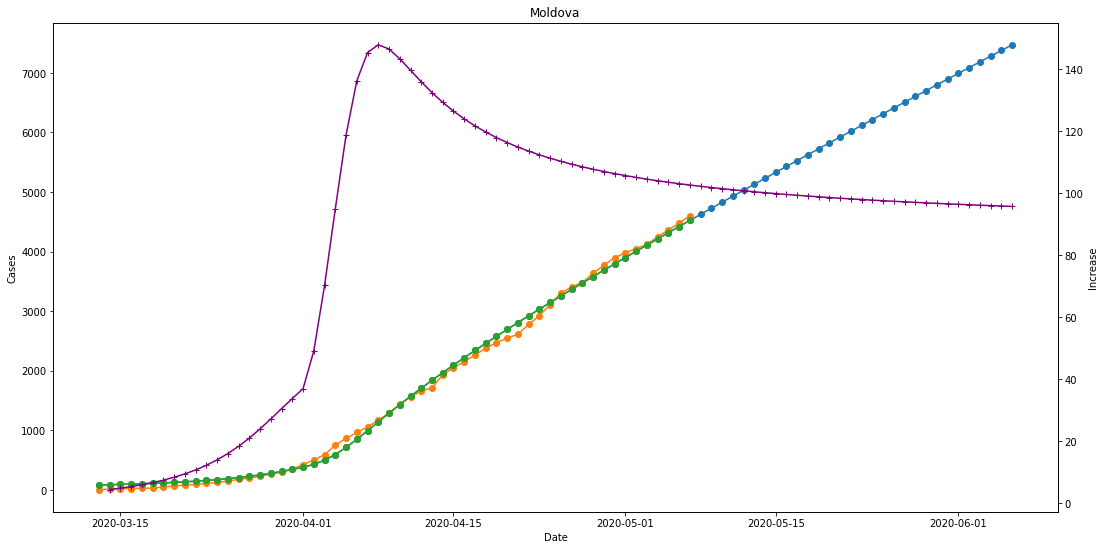

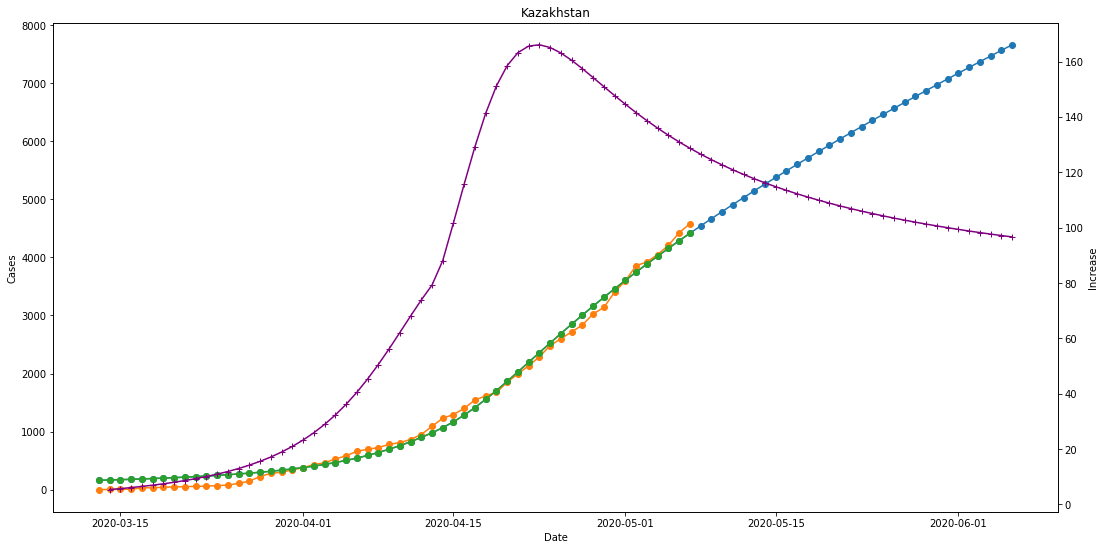

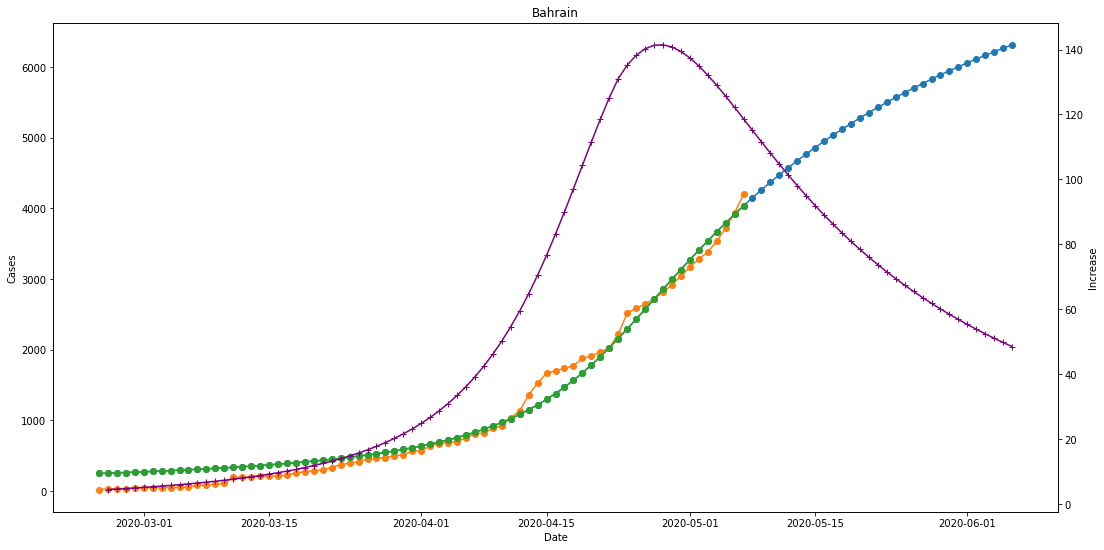

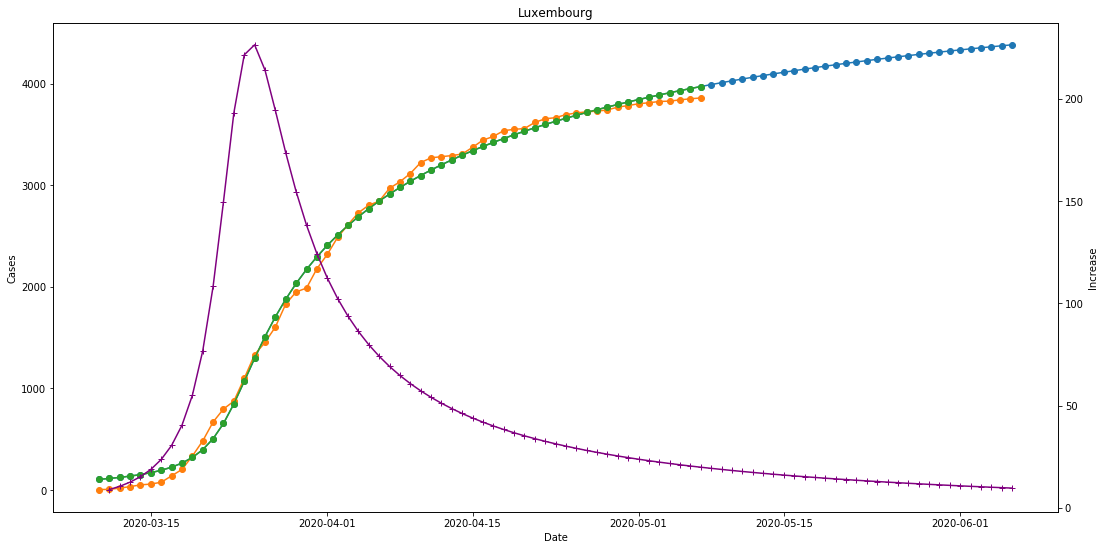

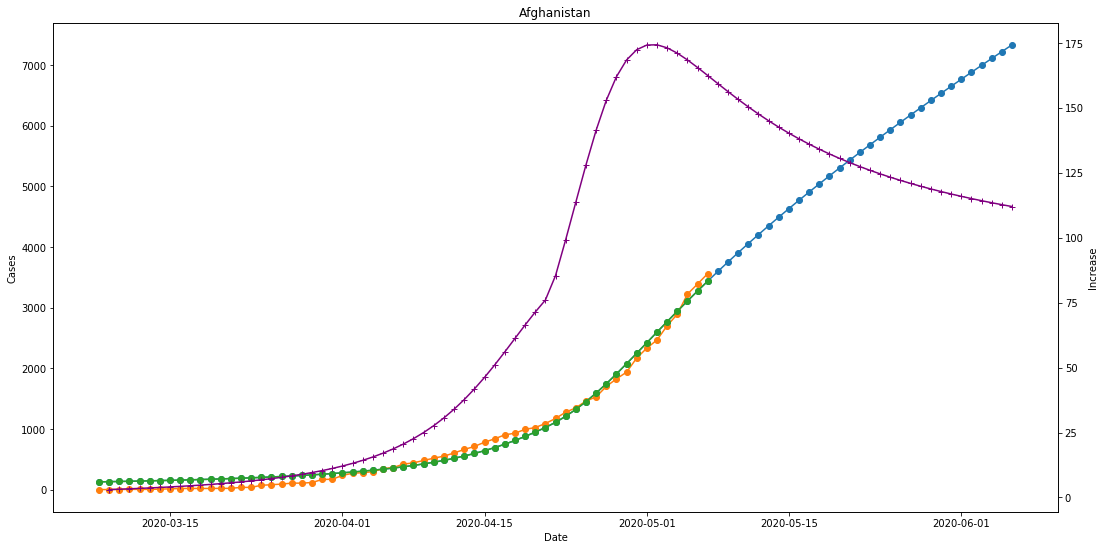

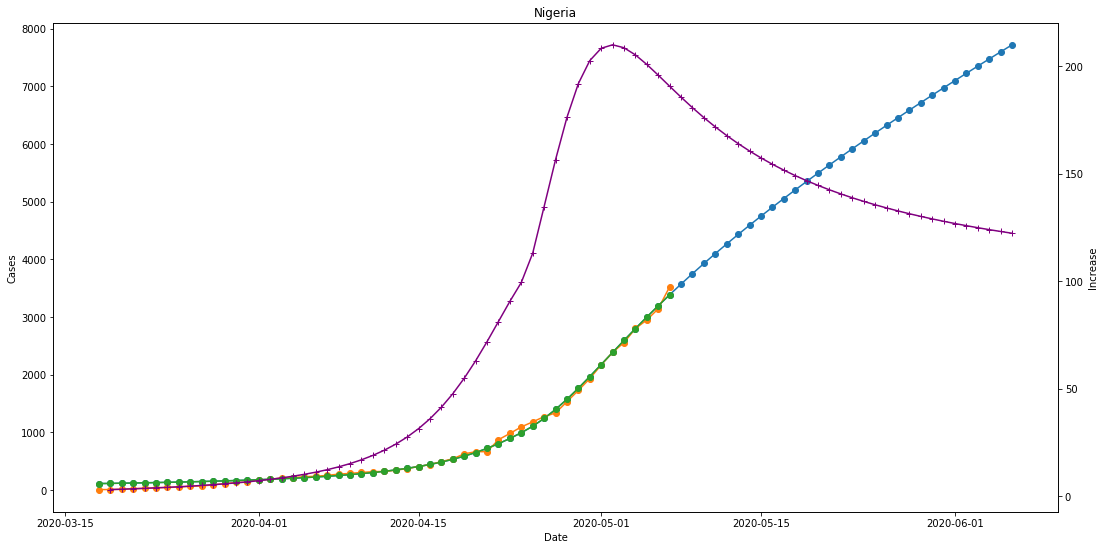

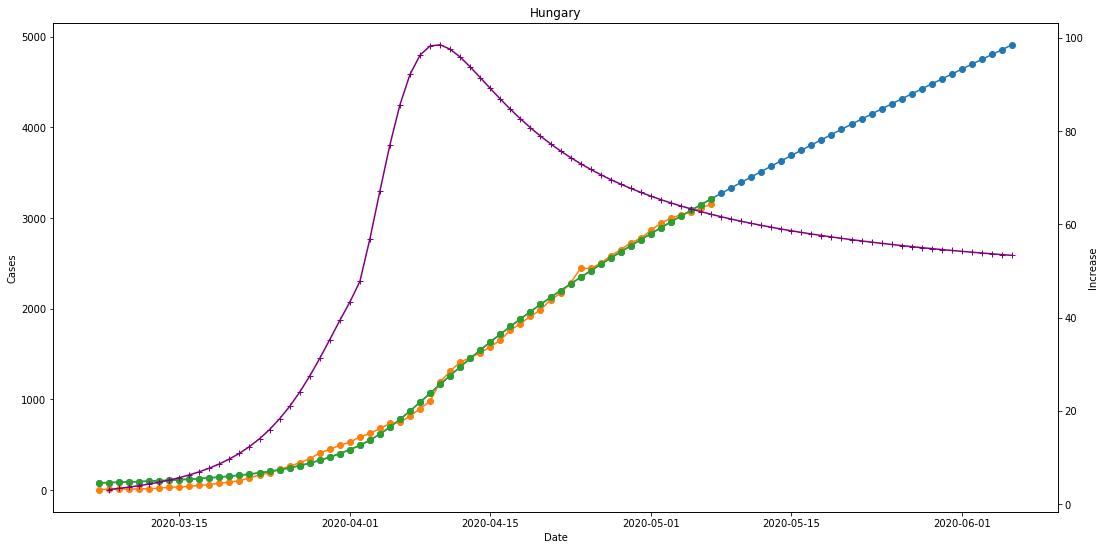

In [22]:
modelsOutput=pd.DataFrame({'Locations':[],'x0':[],'s':[],'A':[],'M':[],'ndata':[],'chisqr':[],'redchi':[],'aic':[],'bic':[]})
imodel=0

for theCountry in Top21_Confirmed:
    modelsOutput.ix[imodel,0]=theCountry
    threshhold=3
    theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

    data=theData[theCountry]
    start_date= data.index[0]
    end_date= data.index[-1]                           
    dateData=pd.date_range(start=start_date,end=end_date)
    forecastDays=30

    dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
    dateObsForecast=dateData.append(dateForecast)
    #dateObsForecast


    # define objective function: returns the array to be minimized
      # normalize case data
    last=data[-1]
    data=data/last
      # set x values interval = 1day
    dataLen=data.count()
    x = np.linspace(1, dataLen, dataLen)

    # create a set of Parameters
    params = Parameters()
    params.add('amp', value=1)
    params.add('scale', value=1, min=0.1)
    params.add('loc', value=70, min=0)
    #params.add('decaybase',value=1,vary=False) #,min=0.9,max=1.005)  # shparly increase value<1(light or mitigation)
    params.add('decaybase',value=1,min=0.85,max=1.005)  # shparly increase value<1(light or mitigation
    # do fit, here with the default leastsq algorithm
    minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
    result = minner.minimize()

    # calculate final result
    forecastdays=forecastDays
    final = data + result.residual
    x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
    scale=result.params['scale'].value
    amp=result.params['amp'].value
    loc=result.params['loc'].value
    decaybase=result.params['decaybase'].value

    y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
    nn=np.int(np.ceil(loc))
    y1[:nn]=final.iloc[:nn] # replace data before

    # write error report
    report_fit(result)

    loc=np.around(loc,decimals=0)
    scale=np.around(scale,decimals=5)
    amp=np.around(amp,decimals=5)
    decaybase=np.around(decaybase,decimals=5)
    ndata=np.around(result.ndata,decimals=0)
    chisqr=np.around(result.chisqr,decimals=4)
    redchi=np.around(result.redchi,decimals=4)
    aic=np.around(result.aic,decimals=0)
    bic=np.around(result.aic,decimals=0)
    modelout=[loc,scale,amp,decaybase,ndata,chisqr,redchi,aic,bic]
    modelsOutput.ix[imodel,1:]=np.transpose(modelout)
    imodel=imodel+1
#modelsOutput
    #modelsOutput.head()
    fig,ax1 = plt.subplots(figsize=(18,9))
    output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
    output['date']=dateObsForecast
    output['Forecast']=y1*last
    output['Cases'].iloc[:dataLen]=data.values*last
    output['Fitting'].iloc[:dataLen]=final.values*last
    output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
    output=output.set_index('date')
    output_cases=output.drop('Increase',axis=1)
    output_increase=output['Increase']
    
    ax1.plot(output.index,output_cases,marker='o')
    ax1.set_ylabel('Cases')
    ax1.set_xlabel('Date')
    ax1.set_title(theCountry)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Increase')
    ax2.plot(output.index,output_increase,color='purple', marker='+')
    figfilename='figs/COVID-19_forecast_for_' + theCountry.replace(" ", "") +'_with4parameters.png'
    fig.savefig(figfilename)    


# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title='Projected COVID-19 Cases in South Kerea')


# fig=output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title='Projected COVID-19 Cases in South Korea',
#              theme='solar',
#              filename='COVID19-South-Korea',
#              sharing='public')
# fig.show()
 

In [23]:
#modelsOutput0=modelsOutput.copy()

In [24]:
# modelsOutput